## Description

In this project, I create a classifier to predict a mammal's taxonomic order based on its ecological, geographic, and life-history traits. The classifier is trained on data from PanTHERIA, a comprehensive species-level database containing trait data for all known extant and recently-extinct mammals. Exploratory data analysis is conducted with Pandas, while preprocessing, model selection, and hyperparameter tuning are performed in Scikit-learn. After numerous rounds of cross validation within the training set, the best-performing model was found to be a histogram-based gradient boosting classifier with a learning rate of 0.01, a minimum leaf size of 50, and a maximum of 2000 iterations of the boosting process. As part of the classification pipeline, this model also:
- transformed both positively-skewed and negatively-skewed numeric features 
- standardized all numeric features
- leveraged the native support for missing values and categorical features offered by Scikit-learn's ```HistGradientBoostingClassifier```
- undersampled the majority order&mdash;Rodentia&mdash;to one-fourth its prevalence in the training set

Ultimately, when evaluated on the test set, the classifier achieved a balanced accuracy score of 0.785, with all but two of the ten considered orders attaining a recall score of at least 0.75. While not a substitute for methodical phylogenetic reconstruction, this model helps illuminate some of the central affinities within the mammalian class; it is no coincidence, for example, that the classifier was particularly prone to characterizing cetaceans as artiodactyls&mdash;a striking reflection of their close evolutionary kinship.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import skew, randint
import pickle

## Data Importing and Preliminary Cleaning

In [2]:
df = pd.read_csv('../data/pantheria_data.txt', sep='\t', na_values='-999')
pd.set_option('display.max_columns', None)
df

MSW05_Order MSW05_Family MSW05_Genus MSW05_Species  \
0     Artiodactyla    Camelidae     Camelus   dromedarius   
1        Carnivora      Canidae       Canis       adustus   
2        Carnivora      Canidae       Canis        aureus   
3        Carnivora      Canidae       Canis       latrans   
4        Carnivora      Canidae       Canis         lupus   
...            ...          ...         ...           ...   
5411      Rodentia      Muridae     Zyzomys       argurus   
5412      Rodentia      Muridae     Zyzomys         maini   
5413      Rodentia      Muridae     Zyzomys     palatilis   
5414      Rodentia      Muridae     Zyzomys  pedunculatus   
5415      Rodentia      Muridae     Zyzomys     woodwardi   

            MSW05_Binomial  1-1_ActivityCycle  5-1_AdultBodyMass_g  \
0      Camelus dromedarius                3.0            492714.47   
1            Canis adustus                1.0             10392.49   
2             Canis aureus                2.0              9658.70   
3            Canis latrans                2.0             11989.10   
4              Canis lupus                2.0             31756.51   
...                    ...                ...                  ...   
5411       Zyzomys argurus                NaN                40.42   
5412         Zyzomys maini                NaN                93.99   
5413     Zyzomys palatilis                NaN               123.00   
5414  Zyzomys pedunculatus                NaN               100.00   
5415     Zyzomys woodwardi                NaN                95.02   

      8-1_AdultForearmLen_mm  13-1_AdultHeadBodyLen_mm  2-1_AgeatEyeOpening_d  \
0                        NaN                       NaN                    NaN   
1                        NaN                    745.32                    NaN   
2                        NaN                    827.53                   7.50   
3                        NaN                    872.39                  11.94   
4                        NaN                   1055.00                  14.01   
...                      ...                       ...                    ...   
5411                     NaN                    107.83                    NaN   
5412                     NaN                       NaN                    NaN   
5413                     NaN                       NaN                    NaN   
5414                     NaN                    126.79                    NaN   
5415                     NaN                    146.07                    NaN   

      3-1_AgeatFirstBirth_d  18-1_BasalMetRate_mLO2hr  5-2_BasalMetRateMass_g  \
0                   1651.62                   40293.0                407000.0   
1                       NaN                       NaN                     NaN   
2                       NaN                       NaN                     NaN   
3                    365.00                    3699.0                 10450.0   
4                    547.50                   11254.2                 33100.0   
...                     ...                       ...                     ...   
5411                    NaN                       NaN                     NaN   
5412                    NaN                       NaN                     NaN   
5413                    NaN                       NaN                     NaN   
5414                    NaN                       NaN                     NaN   
5415                    NaN                       NaN                     NaN   

      6-1_DietBreadth  7-1_DispersalAge_d  9-1_GestationLen_d  \
0                 3.0                 NaN              386.51   
1                 6.0              329.99               65.00   
2                 6.0                 NaN               61.24   
3                 1.0              255.00               61.74   
4                 1.0              180.00               63.50   
...               ...                 ...                 ...   
5411              NaN           

In [3]:
df = df.drop('References', axis=1)

# Renaming columns to remove leading quantifiers
renamed_columns = {column: column.split('_', maxsplit=1)[1] for column in df.columns}
df = df.rename(renamed_columns, axis=1)
df

Order     Family    Genus       Species              Binomial  \
0     Artiodactyla  Camelidae  Camelus   dromedarius   Camelus dromedarius   
1        Carnivora    Canidae    Canis       adustus         Canis adustus   
2        Carnivora    Canidae    Canis        aureus          Canis aureus   
3        Carnivora    Canidae    Canis       latrans         Canis latrans   
4        Carnivora    Canidae    Canis         lupus           Canis lupus   
...            ...        ...      ...           ...                   ...   
5411      Rodentia    Muridae  Zyzomys       argurus       Zyzomys argurus   
5412      Rodentia    Muridae  Zyzomys         maini         Zyzomys maini   
5413      Rodentia    Muridae  Zyzomys     palatilis     Zyzomys palatilis   
5414      Rodentia    Muridae  Zyzomys  pedunculatus  Zyzomys pedunculatus   
5415      Rodentia    Muridae  Zyzomys     woodwardi     Zyzomys woodwardi   

      ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  AdultHeadBodyLen_mm  \
0               3.0        492714.47                 NaN                  NaN   
1               1.0         10392.49                 NaN               745.32   
2               2.0          9658.70                 NaN               827.53   
3               2.0         11989.10                 NaN               872.39   
4               2.0         31756.51                 NaN              1055.00   
...             ...              ...                 ...                  ...   
5411            NaN            40.42                 NaN               107.83   
5412            NaN            93.99                 NaN                  NaN   
5413            NaN           123.00                 NaN                  NaN   
5414            NaN           100.00                 NaN               126.79   
5415            NaN            95.02                 NaN               146.07   

      AgeatEyeOpening_d  AgeatFirstBirth_d  BasalMetRate_mLO2hr  \
0                   NaN            1651.62              40293.0   
1                   NaN                NaN                  NaN   
2                  7.50                NaN                  NaN   
3                 11.94             365.00               3699.0   
4                 14.01             547.50              11254.2   
...                 ...                ...                  ...   
5411                NaN                NaN                  NaN   
5412                NaN                NaN                  NaN   
5413                NaN                NaN                  NaN   
5414                NaN                NaN                  NaN   
5415                NaN                NaN                  NaN   

      BasalMetRateMass_g  DietBreadth  DispersalAge_d  GestationLen_d  \
0               407000.0          3.0             NaN          386.51   
1                    NaN          6.0          329.99           65.00   
2                    NaN          6.0             NaN           61.24   
3                10450.0          1.0          255.00           61.74   
4                33100.0          1.0          180.00           63.50   
...                  ...          ...             ...             ...   
5411                 NaN          NaN             NaN           25.00   
5412                 NaN          NaN             NaN             NaN   
5413                 NaN          NaN             NaN             NaN   
5414                 NaN          NaN             NaN             NaN   
5415                 NaN          NaN             NaN             NaN   

      HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
0                1.0      196.32000                  NaN   
1                1.0        1.01000             1.010000   
2                1.0        2.95000             3.130000   
3                1.0       18.88000            19.910000   
4                1.0      159.86000            43.130000   
...              ...            ...                  ...   
5

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5416 entries, 0 to 5415
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order                    5416 non-null   object 
 1   Family                   5416 non-null   object 
 2   Genus                    5416 non-null   object 
 3   Species                  5416 non-null   object 
 4   Binomial                 5416 non-null   object 
 5   ActivityCycle            1659 non-null   float64
 6   AdultBodyMass_g          3542 non-null   float64
 7   AdultForearmLen_mm       903 non-null    float64
 8   AdultHeadBodyLen_mm      1941 non-null   float64
 9   AgeatEyeOpening_d        476 non-null    float64
 10  AgeatFirstBirth_d        445 non-null    float64
 11  BasalMetRate_mLO2hr      573 non-null    float64
 12  BasalMetRateMass_g       573 non-null    float64
 13  DietBreadth              2161 non-null   float64
 14  DispersalAge_d          

In [5]:
df['Order'].nunique()  # Number of orders in total

29

In [6]:
df['Order'].value_counts()

Rodentia            2277
Chiroptera          1116
Soricomorpha         428
Primates             376
Carnivora            286
Artiodactyla         240
Diprotodontia        143
Lagomorpha            92
Didelphimorphia       87
Cetacea               84
Dasyuromorphia        71
Afrosoricida          51
Erinaceomorpha        24
Cingulata             21
Peramelemorphia       21
Scandentia            20
Perissodactyla        17
Macroscelidea         15
Pilosa                10
Pholidota              8
Paucituberculata       6
Sirenia                5
Monotremata            5
Hyracoidea             4
Proboscidea            3
Dermoptera             2
Notoryctemorphia       2
Microbiotheria         1
Tubulidentata          1
Name: Order, dtype: int64

Due to limited data in certain orders, only orders having more than 80 instances will be considered. This represents a total of 10 orders: Rodentia, Chiroptera, Soricomorpha, Primates, Carnivora, Artiodactyla, Diprotodontia, Lagomorpha, Didelphimorphia, and Cetacea.

In [7]:
orders_to_keep = df['Order'].value_counts()[:10].index
df = df[df['Order'].isin(orders_to_keep)]
df

Order     Family    Genus       Species              Binomial  \
0     Artiodactyla  Camelidae  Camelus   dromedarius   Camelus dromedarius   
1        Carnivora    Canidae    Canis       adustus         Canis adustus   
2        Carnivora    Canidae    Canis        aureus          Canis aureus   
3        Carnivora    Canidae    Canis       latrans         Canis latrans   
4        Carnivora    Canidae    Canis         lupus           Canis lupus   
...            ...        ...      ...           ...                   ...   
5411      Rodentia    Muridae  Zyzomys       argurus       Zyzomys argurus   
5412      Rodentia    Muridae  Zyzomys         maini         Zyzomys maini   
5413      Rodentia    Muridae  Zyzomys     palatilis     Zyzomys palatilis   
5414      Rodentia    Muridae  Zyzomys  pedunculatus  Zyzomys pedunculatus   
5415      Rodentia    Muridae  Zyzomys     woodwardi     Zyzomys woodwardi   

      ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  AdultHeadBodyLen_mm  \
0               3.0        492714.47                 NaN                  NaN   
1               1.0         10392.49                 NaN               745.32   
2               2.0          9658.70                 NaN               827.53   
3               2.0         11989.10                 NaN               872.39   
4               2.0         31756.51                 NaN              1055.00   
...             ...              ...                 ...                  ...   
5411            NaN            40.42                 NaN               107.83   
5412            NaN            93.99                 NaN                  NaN   
5413            NaN           123.00                 NaN                  NaN   
5414            NaN           100.00                 NaN               126.79   
5415            NaN            95.02                 NaN               146.07   

      AgeatEyeOpening_d  AgeatFirstBirth_d  BasalMetRate_mLO2hr  \
0                   NaN            1651.62              40293.0   
1                   NaN                NaN                  NaN   
2                  7.50                NaN                  NaN   
3                 11.94             365.00               3699.0   
4                 14.01             547.50              11254.2   
...                 ...                ...                  ...   
5411                NaN                NaN                  NaN   
5412                NaN                NaN                  NaN   
5413                NaN                NaN                  NaN   
5414                NaN                NaN                  NaN   
5415                NaN                NaN                  NaN   

      BasalMetRateMass_g  DietBreadth  DispersalAge_d  GestationLen_d  \
0               407000.0          3.0             NaN          386.51   
1                    NaN          6.0          329.99           65.00   
2                    NaN          6.0             NaN           61.24   
3                10450.0          1.0          255.00           61.74   
4                33100.0          1.0          180.00           63.50   
...                  ...          ...             ...             ...   
5411                 NaN          NaN             NaN           25.00   
5412                 NaN          NaN             NaN             NaN   
5413                 NaN          NaN             NaN             NaN   
5414                 NaN          NaN             NaN             NaN   
5415                 NaN          NaN             NaN             NaN   

      HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
0                1.0      196.32000                  NaN   
1                1.0        1.01000             1.010000   
2                1.0        2.95000             3.130000   
3                1.0       18.88000            19.910000   
4                1.0      159.86000            43.130000   
...              ...            ...                  ...   
5

In [8]:
df.describe().round()

ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  \
count         1467.0           3301.0               903.0   
mean             2.0         181953.0                55.0   
std              1.0        3374157.0                30.0   
min              1.0              2.0                23.0   
25%              1.0             25.0                37.0   
50%              2.0            100.0                45.0   
75%              3.0           1391.0                58.0   
max              3.0      154321304.0               246.0   

       AdultHeadBodyLen_mm  AgeatEyeOpening_d  AgeatFirstBirth_d  \
count               1769.0              451.0              424.0   
mean                 561.0               15.0              801.0   
std                 1446.0               16.0              774.0   
min                   31.0                0.0               39.0   
25%                  118.0                4.0              318.0   
50%                  210.0               12.0              559.0   
75%                  524.0               19.0             1095.0   
max                30480.0              154.0             5457.0   

       BasalMetRate_mLO2hr  BasalMetRateMass_g  DietBreadth  DispersalAge_d  \
count                493.0               493.0       1977.0           132.0   
mean                2085.0              8543.0          3.0           397.0   
std                 8690.0             39300.0          2.0           534.0   
min                    6.0                 4.0          1.0            16.0   
25%                   44.0                28.0          1.0           103.0   
50%                   98.0                94.0          2.0           287.0   
75%                  431.0               812.0          4.0           529.0   
max               113712.0            407000.0          8.0          5249.0   

       GestationLen_d  HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
count          1234.0          2511.0          651.0                572.0   
mean            109.0             1.0          253.0                355.0   
std              95.0             1.0         4336.0               5832.0   
min              12.0             1.0            0.0                  0.0   
25%              30.0             1.0            0.0                  0.0   
50%              73.0             1.0            0.0                  0.0   
75%             166.0             2.0            1.0                  1.0   
max             479.0             4.0        79245.0             112250.0   

       InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
count                 616.0      2311.0           809.0           898.0   
mean                  328.0         2.0             2.0           200.0   
std                   292.0         2.0             1.0           166.0   
min                    17.0         1.0             0.0            10.0   
25%                   112.0         1.0             1.0            84.0   
50%                   353.0         2.0             2.0           170.0   
75%                   365.0         3.0             2.0           264.0   
max                  2008.0        12.0            10.0          1470.0   

       NeonateBodyMass_g  NeonateHeadBodyLen_mm  PopulationDensity_n/km2  \
count             1004.0                  200.0                    878.0   
mean             10792.0                  344.0                    838.0   
std             121946.0                 1142.0                   3040.0   
min                  0.0                    8.0                      0.0   
25%                  3.0                   29.0                      7.0   
50%                 13.0                   41.0                     57.0   
75%                321.0                   91.0                    520.0   
max            2738613.0                 7600.0                  57068.0   

       PopulationGrpSize  SexualMaturityAge_d  SocialGrpSize  TeatNumber  \
c

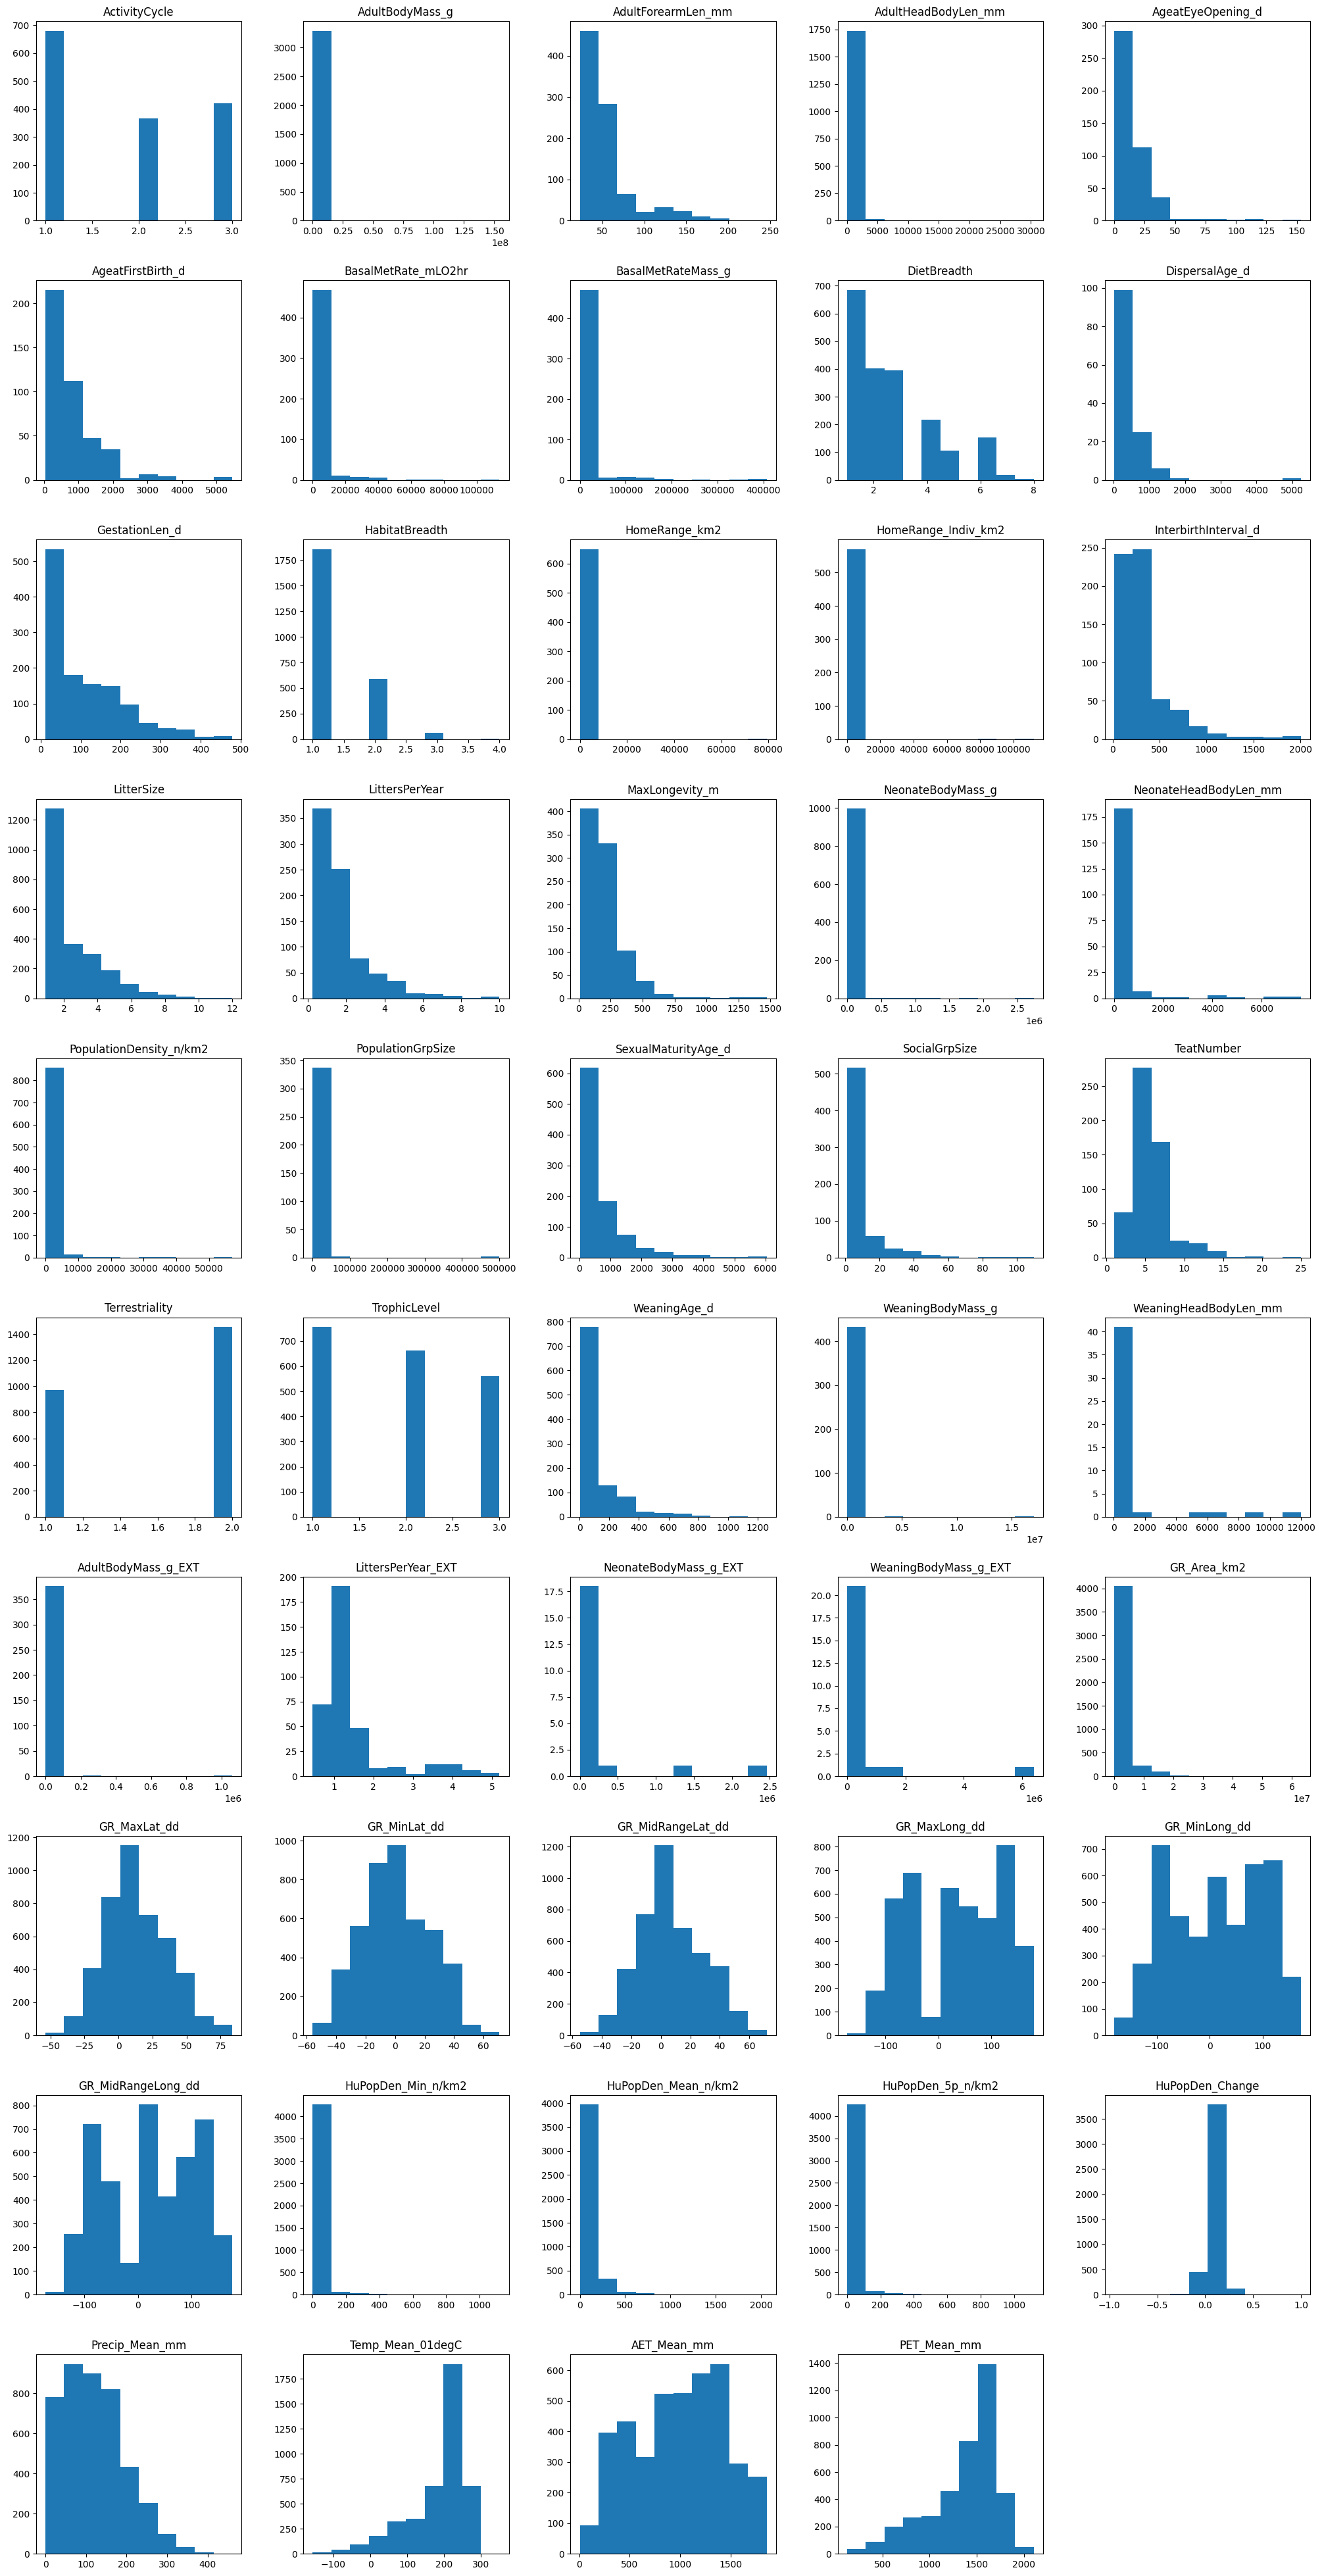

In [9]:
# Visualizing distributions/categories of all features

df.hist(figsize=(25, 50), layout=(10, 5), grid=False)
plt.show()

In [10]:
df = df.drop(df.columns[1:5], axis=1)  # Dropping non-order taxonomic columns
df

Order  ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  \
0     Artiodactyla            3.0        492714.47                 NaN   
1        Carnivora            1.0         10392.49                 NaN   
2        Carnivora            2.0          9658.70                 NaN   
3        Carnivora            2.0         11989.10                 NaN   
4        Carnivora            2.0         31756.51                 NaN   
...            ...            ...              ...                 ...   
5411      Rodentia            NaN            40.42                 NaN   
5412      Rodentia            NaN            93.99                 NaN   
5413      Rodentia            NaN           123.00                 NaN   
5414      Rodentia            NaN           100.00                 NaN   
5415      Rodentia            NaN            95.02                 NaN   

      AdultHeadBodyLen_mm  AgeatEyeOpening_d  AgeatFirstBirth_d  \
0                     NaN                NaN            1651.62   
1                  745.32                NaN                NaN   
2                  827.53               7.50                NaN   
3                  872.39              11.94             365.00   
4                 1055.00              14.01             547.50   
...                   ...                ...                ...   
5411               107.83                NaN                NaN   
5412                  NaN                NaN                NaN   
5413                  NaN                NaN                NaN   
5414               126.79                NaN                NaN   
5415               146.07                NaN                NaN   

      BasalMetRate_mLO2hr  BasalMetRateMass_g  DietBreadth  DispersalAge_d  \
0                 40293.0            407000.0          3.0             NaN   
1                     NaN                 NaN          6.0          329.99   
2                     NaN                 NaN          6.0             NaN   
3                  3699.0             10450.0          1.0          255.00   
4                 11254.2             33100.0          1.0          180.00   
...                   ...                 ...          ...             ...   
5411                  NaN                 NaN          NaN             NaN   
5412                  NaN                 NaN          NaN             NaN   
5413                  NaN                 NaN          NaN             NaN   
5414                  NaN                 NaN          NaN             NaN   
5415                  NaN                 NaN          NaN             NaN   

      GestationLen_d  HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
0             386.51             1.0      196.32000                  NaN   
1              65.00             1.0        1.01000             1.010000   
2              61.24             1.0        2.95000             3.130000   
3              61.74             1.0       18.88000            19.910000   
4              63.50             1.0      159.86000            43.130000   
...              ...             ...            ...                  ...   
5411           25.00             NaN        0.00104             0.000956   
5412             NaN             NaN            NaN                  NaN   
5413             NaN             NaN            NaN                  NaN   
5414             NaN             NaN            NaN                  NaN   
5415             NaN             NaN            NaN                  NaN   

      InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
0                   614.41        0.98             1.0           480.0   
1                      NaN        4.50             NaN           137.0   
2                   365.00        3.74             NaN           192.0   
3                   365.00        5.72             NaN           262.0   
4                   365.00        4.98             2.0           354.0   
...                    ..

There are four columns in the dataset that contain estimates for their underlying parameters. These estimates will be inserted into their respective empirically-derived columns.

In [11]:
columns_to_receive_estimates = ['AdultBodyMass_g', 'LittersPerYear', 'NeonateBodyMass_g', 'WeaningBodyMass_g']

for column in columns_to_receive_estimates:
    estimated_column = column + '_EXT'  # "_EXT" is how the estimated columns are suffixed
    df[column] = df[column].fillna(df[estimated_column])
    df = df.drop(estimated_column, axis=1)

df

Order  ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  \
0     Artiodactyla            3.0        492714.47                 NaN   
1        Carnivora            1.0         10392.49                 NaN   
2        Carnivora            2.0          9658.70                 NaN   
3        Carnivora            2.0         11989.10                 NaN   
4        Carnivora            2.0         31756.51                 NaN   
...            ...            ...              ...                 ...   
5411      Rodentia            NaN            40.42                 NaN   
5412      Rodentia            NaN            93.99                 NaN   
5413      Rodentia            NaN           123.00                 NaN   
5414      Rodentia            NaN           100.00                 NaN   
5415      Rodentia            NaN            95.02                 NaN   

      AdultHeadBodyLen_mm  AgeatEyeOpening_d  AgeatFirstBirth_d  \
0                     NaN                NaN            1651.62   
1                  745.32                NaN                NaN   
2                  827.53               7.50                NaN   
3                  872.39              11.94             365.00   
4                 1055.00              14.01             547.50   
...                   ...                ...                ...   
5411               107.83                NaN                NaN   
5412                  NaN                NaN                NaN   
5413                  NaN                NaN                NaN   
5414               126.79                NaN                NaN   
5415               146.07                NaN                NaN   

      BasalMetRate_mLO2hr  BasalMetRateMass_g  DietBreadth  DispersalAge_d  \
0                 40293.0            407000.0          3.0             NaN   
1                     NaN                 NaN          6.0          329.99   
2                     NaN                 NaN          6.0             NaN   
3                  3699.0             10450.0          1.0          255.00   
4                 11254.2             33100.0          1.0          180.00   
...                   ...                 ...          ...             ...   
5411                  NaN                 NaN          NaN             NaN   
5412                  NaN                 NaN          NaN             NaN   
5413                  NaN                 NaN          NaN             NaN   
5414                  NaN                 NaN          NaN             NaN   
5415                  NaN                 NaN          NaN             NaN   

      GestationLen_d  HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
0             386.51             1.0      196.32000                  NaN   
1              65.00             1.0        1.01000             1.010000   
2              61.24             1.0        2.95000             3.130000   
3              61.74             1.0       18.88000            19.910000   
4              63.50             1.0      159.86000            43.130000   
...              ...             ...            ...                  ...   
5411           25.00             NaN        0.00104             0.000956   
5412             NaN             NaN            NaN                  NaN   
5413             NaN             NaN            NaN                  NaN   
5414             NaN             NaN            NaN                  NaN   
5415             NaN             NaN            NaN                  NaN   

      InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
0                   614.41        0.98            1.00           480.0   
1                      NaN        4.50             NaN           137.0   
2                   365.00        3.74            1.10           192.0   
3                   365.00        5.72            1.10           262.0   
4                   365.00        4.98            2.00           354.0   
...                    ..

In [12]:
# Partitioning the data into a train set and a test set

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

## Exploratory Data Analysis

In [13]:
# Reconstituting X_train and y_train for exploratory data analysis

train_df = pd.concat([X_train, pd.Series(y_train)], axis=1).reset_index(drop=True)
train_df

ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  AdultHeadBodyLen_mm  \
0               3.0           992.40                 NaN                  NaN   
1               NaN              NaN                 NaN                  NaN   
2               2.0        177522.90                 NaN              2040.00   
3               NaN            24.26               56.78                  NaN   
4               NaN            15.88               57.83                  NaN   
...             ...              ...                 ...                  ...   
4098            NaN              NaN                 NaN                  NaN   
4099            NaN           100.36                 NaN               137.50   
4100            NaN            37.09                 NaN                88.26   
4101            NaN              NaN                 NaN                  NaN   
4102            NaN            36.52                 NaN               121.05   

      AgeatEyeOpening_d  AgeatFirstBirth_d  BasalMetRate_mLO2hr  \
0                   NaN                NaN                  NaN   
1                   NaN                NaN                  NaN   
2                   NaN              788.4                  NaN   
3                   NaN                NaN                  NaN   
4                   NaN                NaN                  NaN   
...                 ...                ...                  ...   
4098                NaN                NaN                  NaN   
4099                NaN                NaN                  NaN   
4100                NaN                NaN                  NaN   
4101                NaN                NaN                  NaN   
4102                NaN                NaN                  NaN   

      BasalMetRateMass_g  DietBreadth  DispersalAge_d  GestationLen_d  \
0                    NaN          NaN             NaN             NaN   
1                    NaN          NaN             NaN             NaN   
2                    NaN          3.0             NaN          246.00   
3                    NaN          3.0             NaN          121.66   
4                    NaN          NaN             NaN             NaN   
...                  ...          ...             ...             ...   
4098                 NaN          NaN             NaN             NaN   
4099                 NaN          4.0             NaN           25.00   
4100                 NaN          NaN             NaN           28.96   
4101                 NaN          NaN             NaN             NaN   
4102                 NaN          NaN             NaN             NaN   

      HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
0                1.0            NaN                  NaN   
1                NaN            NaN                  NaN   
2                NaN            NaN                  NaN   
3                1.0            NaN                  NaN   
4                1.0            NaN                  NaN   
...              ...            ...                  ...   
4098             NaN            NaN                  NaN   
4099             NaN            NaN                  NaN   
4100             NaN            NaN                  NaN   
4101             NaN            NaN                  NaN   
4102             NaN            NaN                  NaN   

      InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
0                      NaN        1.02             NaN             NaN   
1                      NaN         NaN             NaN             NaN   
2                      NaN        1.00             NaN          317.04   
3                      NaN        1.00            1.00             NaN   
4                      NaN         NaN             NaN             NaN   
...                    ...         ...             ...             ...   
4098                   NaN         NaN             NaN             NaN   
4099                   NaN        4.99

In [14]:
train_df_explore = train_df.copy()

In [15]:
train_df_explore.shape

(4103, 46)

In [16]:
# Percent of data present for each feature

percent_present_total = train_df_explore.notna().sum(axis=0) / len(train_df_explore)
percent_present_total

ActivityCycle              0.278333
AdultBodyMass_g            0.713380
AdultForearmLen_mm         0.175725
AdultHeadBodyLen_mm        0.339995
AgeatEyeOpening_d          0.086766
AgeatFirstBirth_d          0.082135
BasalMetRate_mLO2hr        0.098221
BasalMetRateMass_g         0.098221
DietBreadth                0.380941
DispersalAge_d             0.025835
GestationLen_d             0.242262
HabitatBreadth             0.488911
HomeRange_km2              0.126249
HomeRange_Indiv_km2        0.111138
InterbirthInterval_d       0.118450
LitterSize                 0.449184
LittersPerYear             0.225445
MaxLongevity_m             0.174263
NeonateBodyMass_g          0.197660
NeonateHeadBodyLen_mm      0.038752
PopulationDensity_n/km2    0.169632
PopulationGrpSize          0.062881
SexualMaturityAge_d        0.182306
SocialGrpSize              0.121862
TeatNumber                 0.110407
Terrestriality             0.472825
TrophicLevel               0.380941
WeaningAge_d               0

In [17]:
# Count of data present for each feature, by label (order)

count_present_by_label = train_df_explore.groupby('Order').count()
count_present_by_label

ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  \
Order                                                                 
Artiodactyla                97              169                   3   
Carnivora                  165              200                   1   
Cetacea                      2               62                   0   
Chiroptera                  51              745                 717   
Didelphimorphia             52               59                   0   
Diprotodontia               72              100                   0   
Lagomorpha                  29               63                   0   
Primates                   197              210                   0   
Rodentia                   434             1156                   0   
Soricomorpha                43              163                   0   

                 AdultHeadBodyLen_mm  AgeatEyeOpening_d  AgeatFirstBirth_d  \
Order                                                                        
Artiodactyla                     114                  1                 68   
Carnivora                        190                108                 35   
Cetacea                           36                  0                  4   
Chiroptera                       117                 35                 43   
Didelphimorphia                   53                  3                  5   
Diprotodontia                     47                  7                 28   
Lagomorpha                        58                  4                  3   
Primates                         141                  3                 79   
Rodentia                         552                186                 70   
Soricomorpha                      87                  9                  2   

                 BasalMetRate_mLO2hr  BasalMetRateMass_g  DietBreadth  \
Order                                                                   
Artiodactyla                       9                   9          131   
Carnivora                         54                  54          180   
Cetacea                            0                   0           41   
Chiroptera                        69                  69          362   
Didelphimorphia                   10                  10           33   
Diprotodontia                     21                  21           69   
Lagomorpha                         4                   4           32   
Primates                          21                  21          140   
Rodentia                         199                 199          499   
Soricomorpha                      16                  16           76   

                 DispersalAge_d  GestationLen_d  HabitatBreadth  \
Order                                                             
Artiodactyla                  7             143             113   
Carnivora                    71             134             199   
Cetacea                       0              34              60   
Chiroptera                    0             127             706   
Didelphimorphia               2               7              41   
Diprotodontia                 4              38              91   
Lagomorpha                    0              26              38   
Primates                      2             116             120   
Rodentia                     19             338             570   
Soricomorpha                  1              31              68   

                 HomeRange_km2  HomeRange_Indiv_km2  InterbirthInterval_d  \
Order                                                                       
Artiodactyla                54                   36                    72   
Carnivora                   84                   83                   113   
Cetacea                      2                    2                    18   
Chiroptera                   0                    0                     4   
Didelphimorphia             10                   10                     9   
Diprot

In [18]:
# Dropping features that have insufficient data (either less than 5% non-null in total or fewer than five instances in 5 or more labels)

insufficient_in_total = percent_present_total[percent_present_total < 0.05].index

num_orders_with_less_than_five = ((count_present_by_label < 5).sum(axis=0))
less_than_five_in_five_or_more = num_orders_with_less_than_five[num_orders_with_less_than_five >= 5].index

insufficient_features_to_drop = set(list(insufficient_in_total) + list(less_than_five_in_five_or_more))

train_df_explore = train_df_explore.drop(insufficient_features_to_drop, axis=1)
print(f'Number of features dropped: {len(insufficient_features_to_drop)}')

Number of features dropped: 5


In [19]:
with pd.option_context('display.float_format', '{:.1f}'.format):
    display(train_df_explore.describe())

ActivityCycle  AdultBodyMass_g  AdultHeadBodyLen_mm  AgeatFirstBirth_d  \
count         1142.0           2927.0               1395.0              337.0   
mean             1.8         200217.7                575.4              791.7   
std              0.9        3582451.8               1581.7              776.7   
min              1.0              2.0                 31.0               45.0   
25%              1.0             20.2                116.3              319.4   
50%              2.0             83.7                208.0              555.1   
75%              3.0            914.2                512.9             1047.5   
max              3.0      154321304.5              30480.0             5456.8   

       BasalMetRate_mLO2hr  BasalMetRateMass_g  DietBreadth  GestationLen_d  \
count                403.0               403.0       1563.0           994.0   
mean                2300.6              9372.1          2.6           108.7   
std                 9372.7             42026.1          1.6            93.9   
min                    6.1                 4.0          1.0            12.0   
25%                   43.4                27.0          1.0            30.4   
50%                   93.5                86.5          2.0            74.6   
75%                  414.3               801.0          4.0           165.3   
max               113712.0            407000.0          8.0           473.0   

       HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
count          2006.0          518.0                456.0   
mean              1.3          308.7                435.4   
std               0.5         4858.1               6530.1   
min               1.0            0.0                  0.0   
25%               1.0            0.0                  0.0   
50%               1.0            0.1                  0.0   
75%               2.0            1.0                  0.8   
max               4.0        79244.7             112249.7   

       InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
count                 486.0      1843.0           925.0           715.0   
mean                  328.4         2.5             1.8           197.0   
std                   294.8         1.8             1.3           171.2   
min                    17.0         0.9             0.2             9.6   
25%                   125.5         1.0             1.0            72.0   
50%                   321.0         1.9             1.2           168.0   
75%                   365.0         3.5             2.0           252.0   
max                  2007.5        12.0            10.0          1470.0   

       NeonateBodyMass_g  PopulationDensity_n/km2  PopulationGrpSize  \
count              811.0                    696.0              258.0   
mean             18091.1                    851.7             4831.5   
std             168397.6                   3216.5            44333.5   
min                  0.0                      0.0                1.0   
25%                  2.8                      6.4                2.0   
50%                 11.7                     54.7               12.0   
75%                301.5                    504.4               64.8   
max            2738612.8                  57067.8           500500.0   

       SexualMaturityAge_d  SocialGrpSize  TeatNumber  Terrestriality  \
count                748.0          500.0       453.0          1940.0   
mean                 651.5            7.3         5.4             1.6   
std                  801.9           12.4         2.8             0.5   
min                   21.4            1.0         1.0             1.0   
25%                  170.3            1.0         4.0             1.0   
50%                  377.4            2.0         4.0             2.0   
75%                  793.1            7.9         6.0             2.0   
max                 6041.2          110.0        25.0             2.0   

       TrophicLevel  WeaningAge_

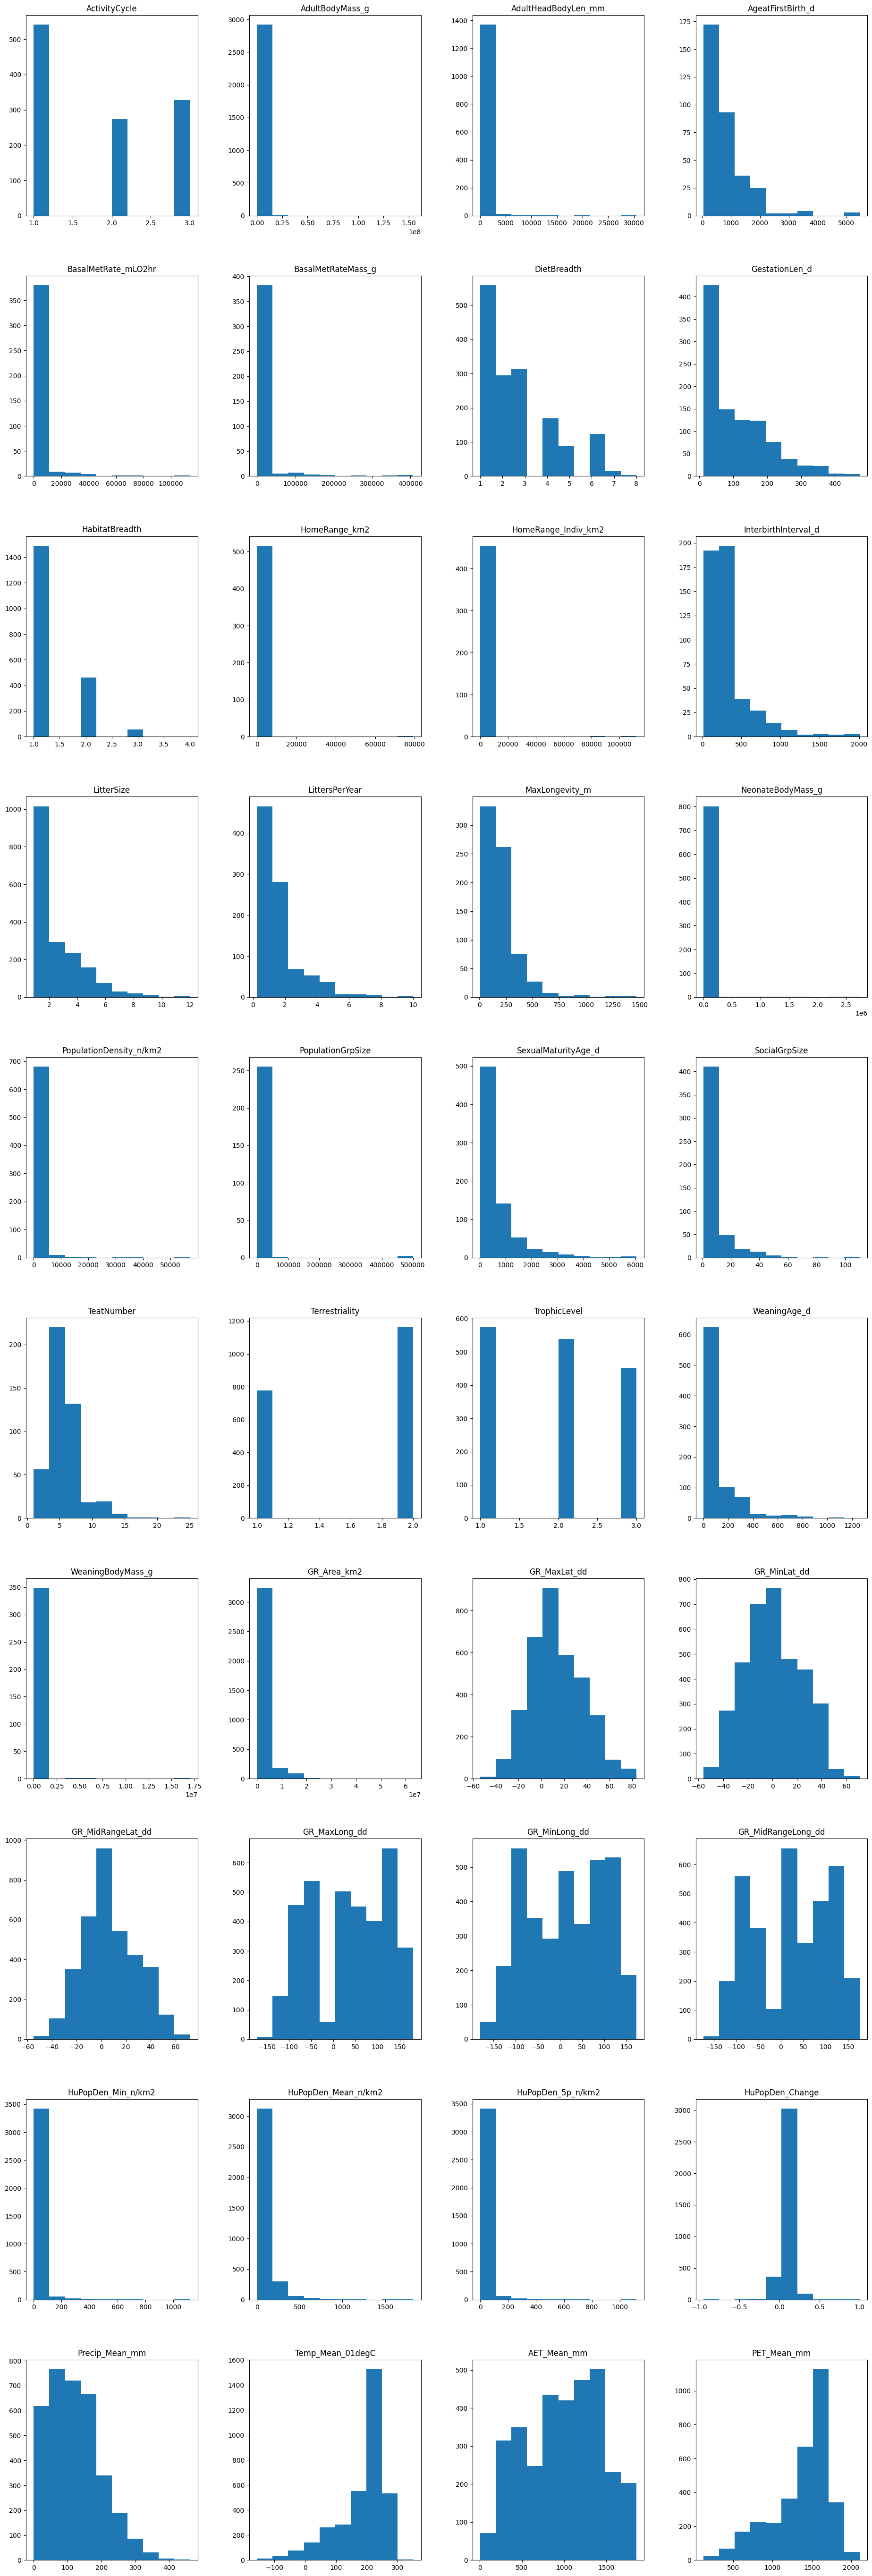

In [20]:
train_df_explore.hist(figsize=(23, 70), layout=(10, 4), sharex=False, sharey=False, grid=False)

plt.show()

In [21]:
# Defining numeric and categorical subsets of the data

categorical_variables = ['ActivityCycle', 'Terrestriality', 'TrophicLevel']
numeric_variables = train_df_explore.columns[~train_df_explore.columns.isin(categorical_variables)]
numeric_variables = list(numeric_variables.drop(['Order']))

num_train_df_explore = train_df_explore[numeric_variables + ['Order']].copy()
cat_train_df_explore = train_df_explore[categorical_variables + ['Order']].copy()

#### Numeric data

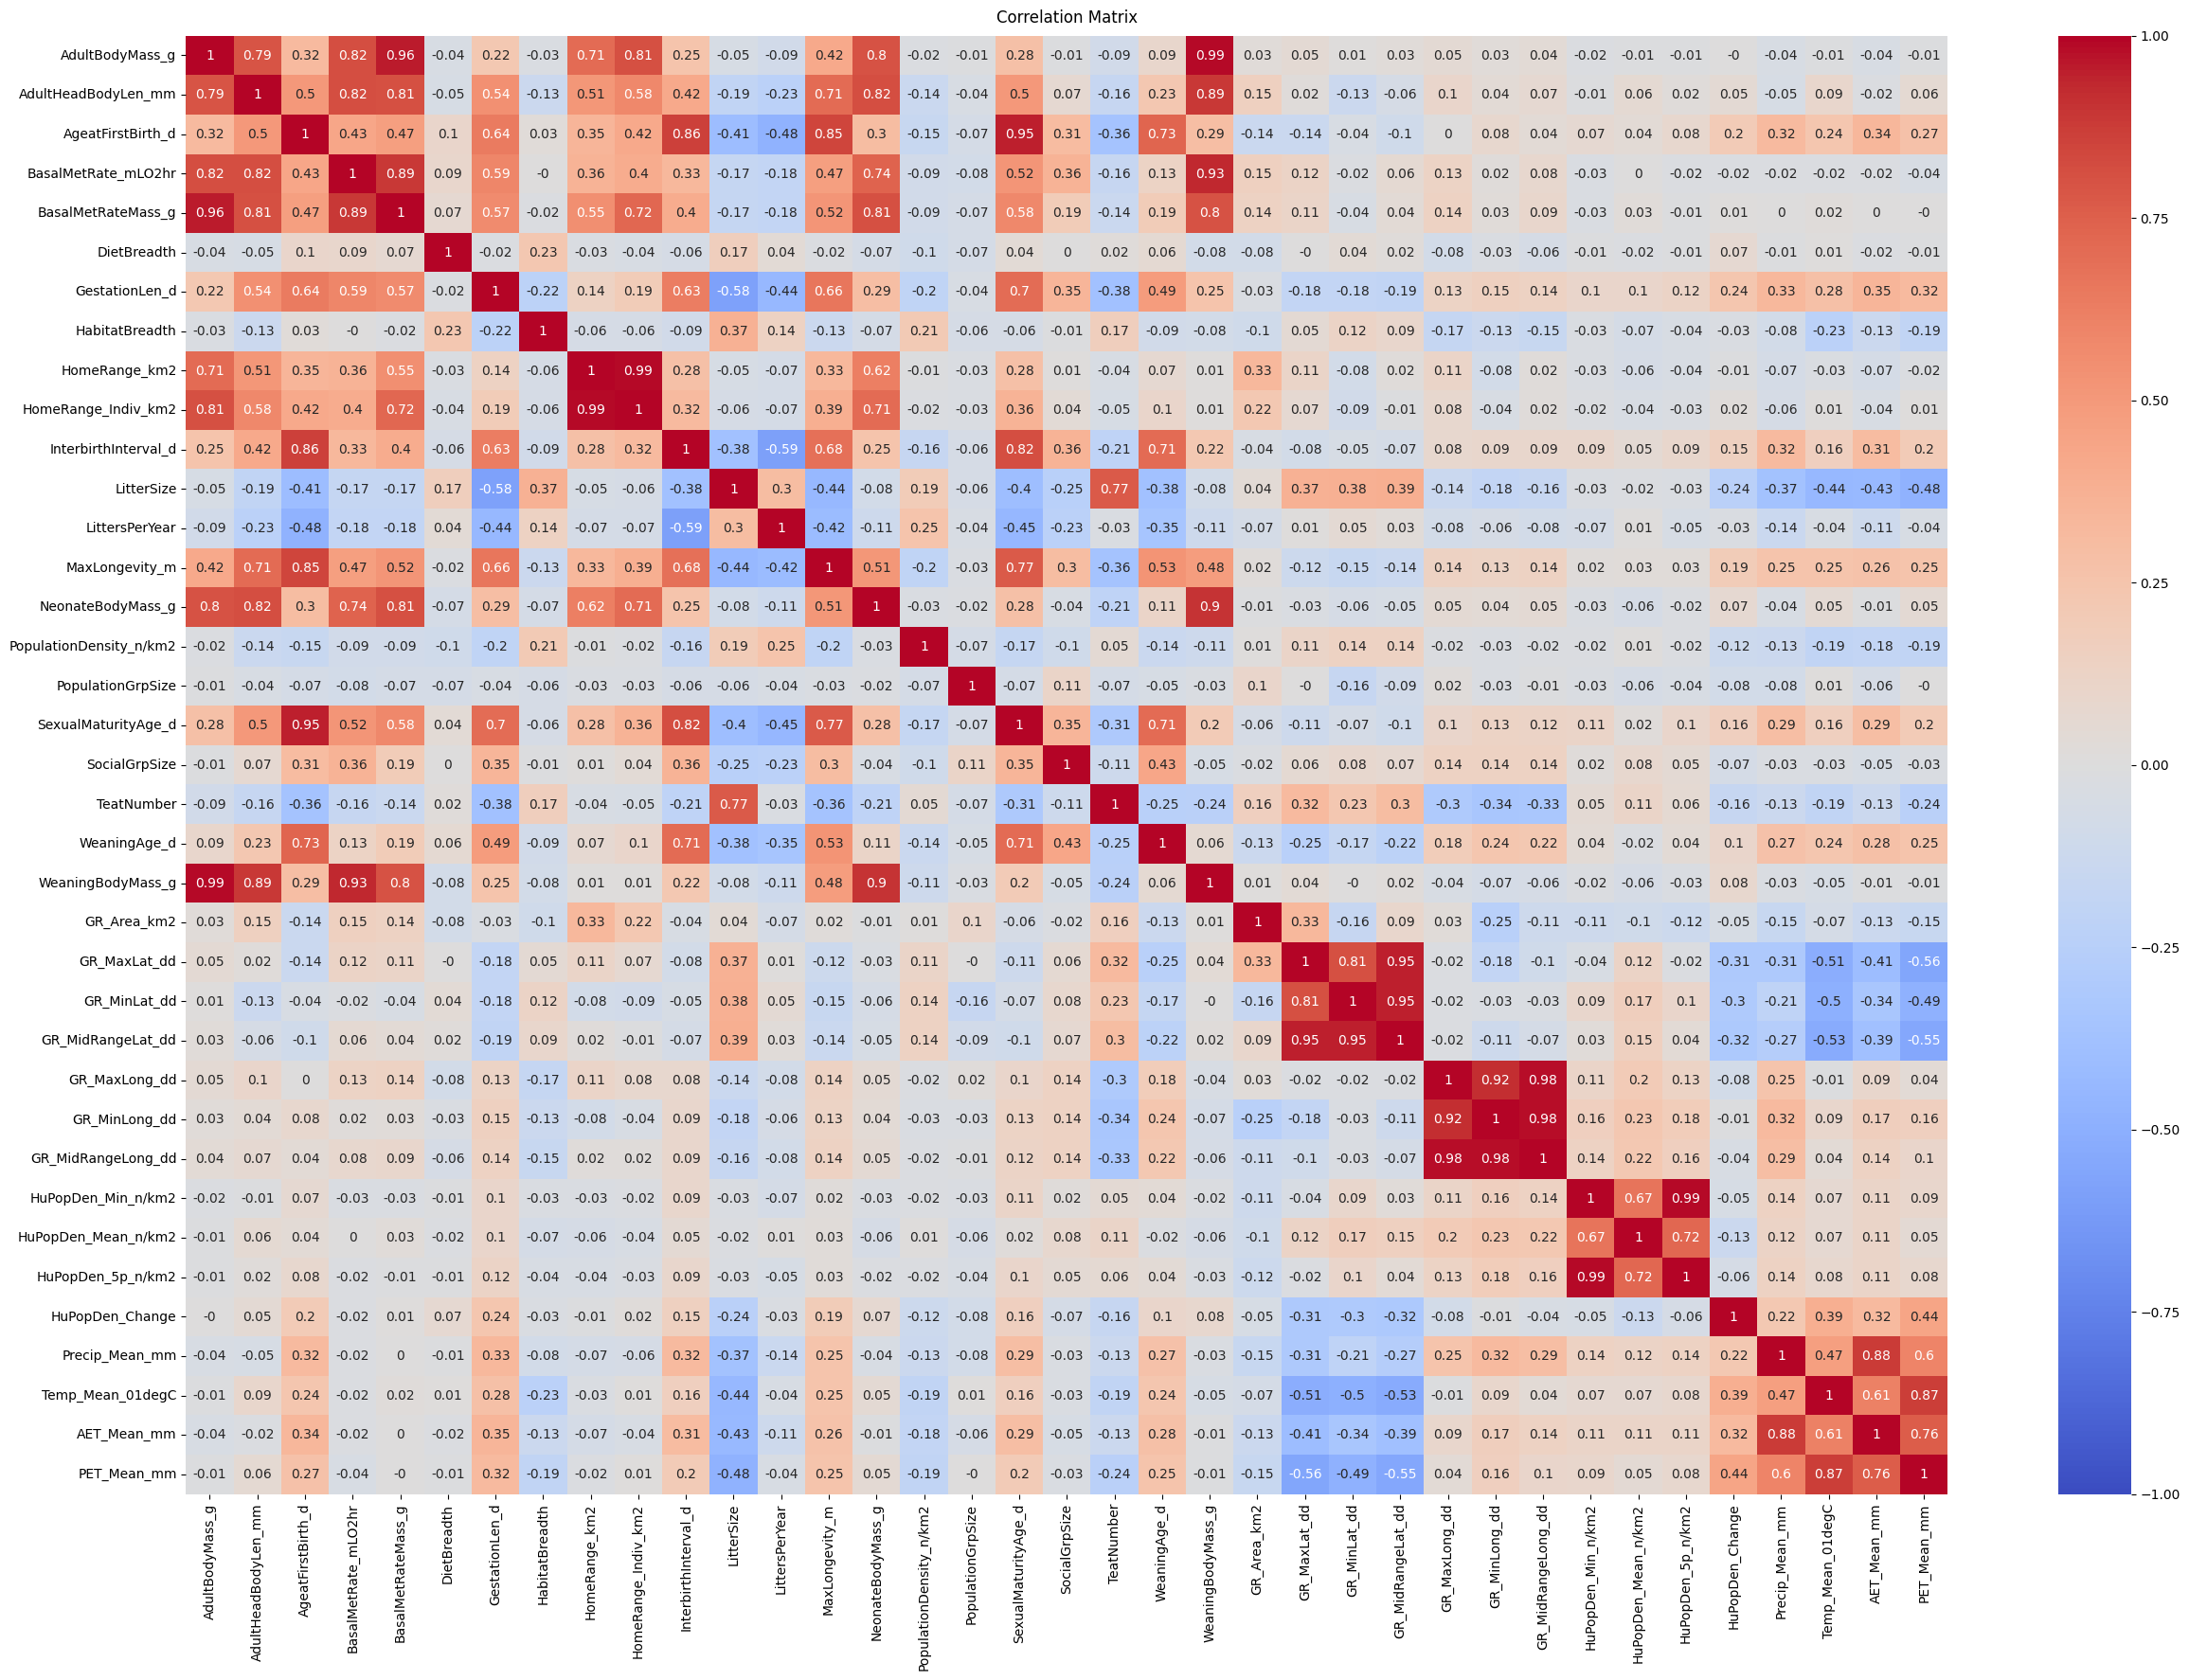

In [22]:
corr_matrix = num_train_df_explore.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', ax=ax, annot=True)
ax.set_title('Correlation Matrix', pad=10)
plt.show()

For the purposes of exploratory data analysis, missing numeric values will be imputed with a K-Nearest Neighbors approach. The imputation strategy to use for the actual classifier, however, will be determined later through cross-validation.

In [23]:
knn_imputer = KNNImputer(n_neighbors=5)
imputed_num_features = knn_imputer.fit_transform(num_train_df_explore.drop('Order', axis=1))
imputed_num_features_df = pd.DataFrame(imputed_num_features, columns=knn_imputer.feature_names_in_)
num_train_df_explore = pd.concat([imputed_num_features_df, num_train_df_explore['Order']], axis=1)
num_train_df_explore

AdultBodyMass_g  AdultHeadBodyLen_mm  AgeatFirstBirth_d  \
0             992.400              385.936            750.804   
1             578.390              191.194           1199.462   
2          177522.900             2040.000            788.400   
3              24.260               98.550            358.624   
4              15.880               74.328            365.398   
...               ...                  ...                ...   
4098          248.396              550.226            722.822   
4099          100.360              137.500            107.726   
4100           37.090               88.260            239.998   
4101         1007.290              462.018           1079.422   
4102           36.520              121.050            239.998   

      BasalMetRate_mLO2hr  BasalMetRateMass_g  DietBreadth  GestationLen_d  \
0                 596.090             983.460          3.0          74.586   
1                  98.988             112.680          4.2          97.906   
2               38878.800          157581.516          3.0         246.000   
3                  16.508              13.268          3.0         121.660   
4                  27.412              16.400          3.0          52.154   
...                   ...                 ...          ...             ...   
4098              452.896             745.960          2.6          69.204   
4099               71.342              69.134          4.0          25.000   
4100               41.602              36.772          2.4          28.960   
4101              105.384             130.380          2.2         108.710   
4102               41.602              36.772          2.4          27.786   

      HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
0                1.0       0.526642             0.578680   
1                1.4       0.162771             0.115300   
2                1.0      31.326456            27.522440   
3                1.0       0.002332             0.002501   
4                1.0       0.001114             0.001355   
...              ...            ...                  ...   
4098             1.4       5.630358             0.084436   
4099             1.0       0.002423             0.002622   
4100             1.6       0.001085             0.001272   
4101             1.4       0.140642             0.047898   
4102             1.8       0.000837             0.000972   

      InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
0                  140.626       1.020           2.586          82.320   
1                  357.358       1.954           1.834         183.552   
2                  400.400       1.000           1.142         317.040   
3                   53.164       1.000           1.000         102.240   
4                   53.164       2.208           2.300         112.440   
...                    ...         ...             ...             ...   
4098               184.528       2.332           2.406         173.592   
4099                53.164       4.990           2.832          37.080   
4100                29.750       3.000           3.910          48.840   
4101               290.350       1.138           1.072         156.792   
4102                53.164       1.200           4.120          48.840   

      NeonateBodyMass_g  PopulationDensity_n/km2  PopulationGrpSize  \
0                 7.944                  150.212             206.40   
1                12.900                   60.874             201.80   
2             10270.000                    4.890              74.10   
3                 7.800                  848.712            7565.80   
4                 2.512                 2811.520            7565.80   
...                 ...                      ...                ...   
4098           1232.922                 3514.406             106.80   
4099              5.662                  819.640            7565.80   
4100              2.622                

In [24]:
# Confirming all missing numeric values have been imputed

num_train_df_explore.notna().sum(axis=0) / len(num_train_df_explore)

AdultBodyMass_g            1.0
AdultHeadBodyLen_mm        1.0
AgeatFirstBirth_d          1.0
BasalMetRate_mLO2hr        1.0
BasalMetRateMass_g         1.0
DietBreadth                1.0
GestationLen_d             1.0
HabitatBreadth             1.0
HomeRange_km2              1.0
HomeRange_Indiv_km2        1.0
InterbirthInterval_d       1.0
LitterSize                 1.0
LittersPerYear             1.0
MaxLongevity_m             1.0
NeonateBodyMass_g          1.0
PopulationDensity_n/km2    1.0
PopulationGrpSize          1.0
SexualMaturityAge_d        1.0
SocialGrpSize              1.0
TeatNumber                 1.0
WeaningAge_d               1.0
WeaningBodyMass_g          1.0
GR_Area_km2                1.0
GR_MaxLat_dd               1.0
GR_MinLat_dd               1.0
GR_MidRangeLat_dd          1.0
GR_MaxLong_dd              1.0
GR_MinLong_dd              1.0
GR_MidRangeLong_dd         1.0
HuPopDen_Min_n/km2         1.0
HuPopDen_Mean_n/km2        1.0
HuPopDen_5p_n/km2          1.0
HuPopDen

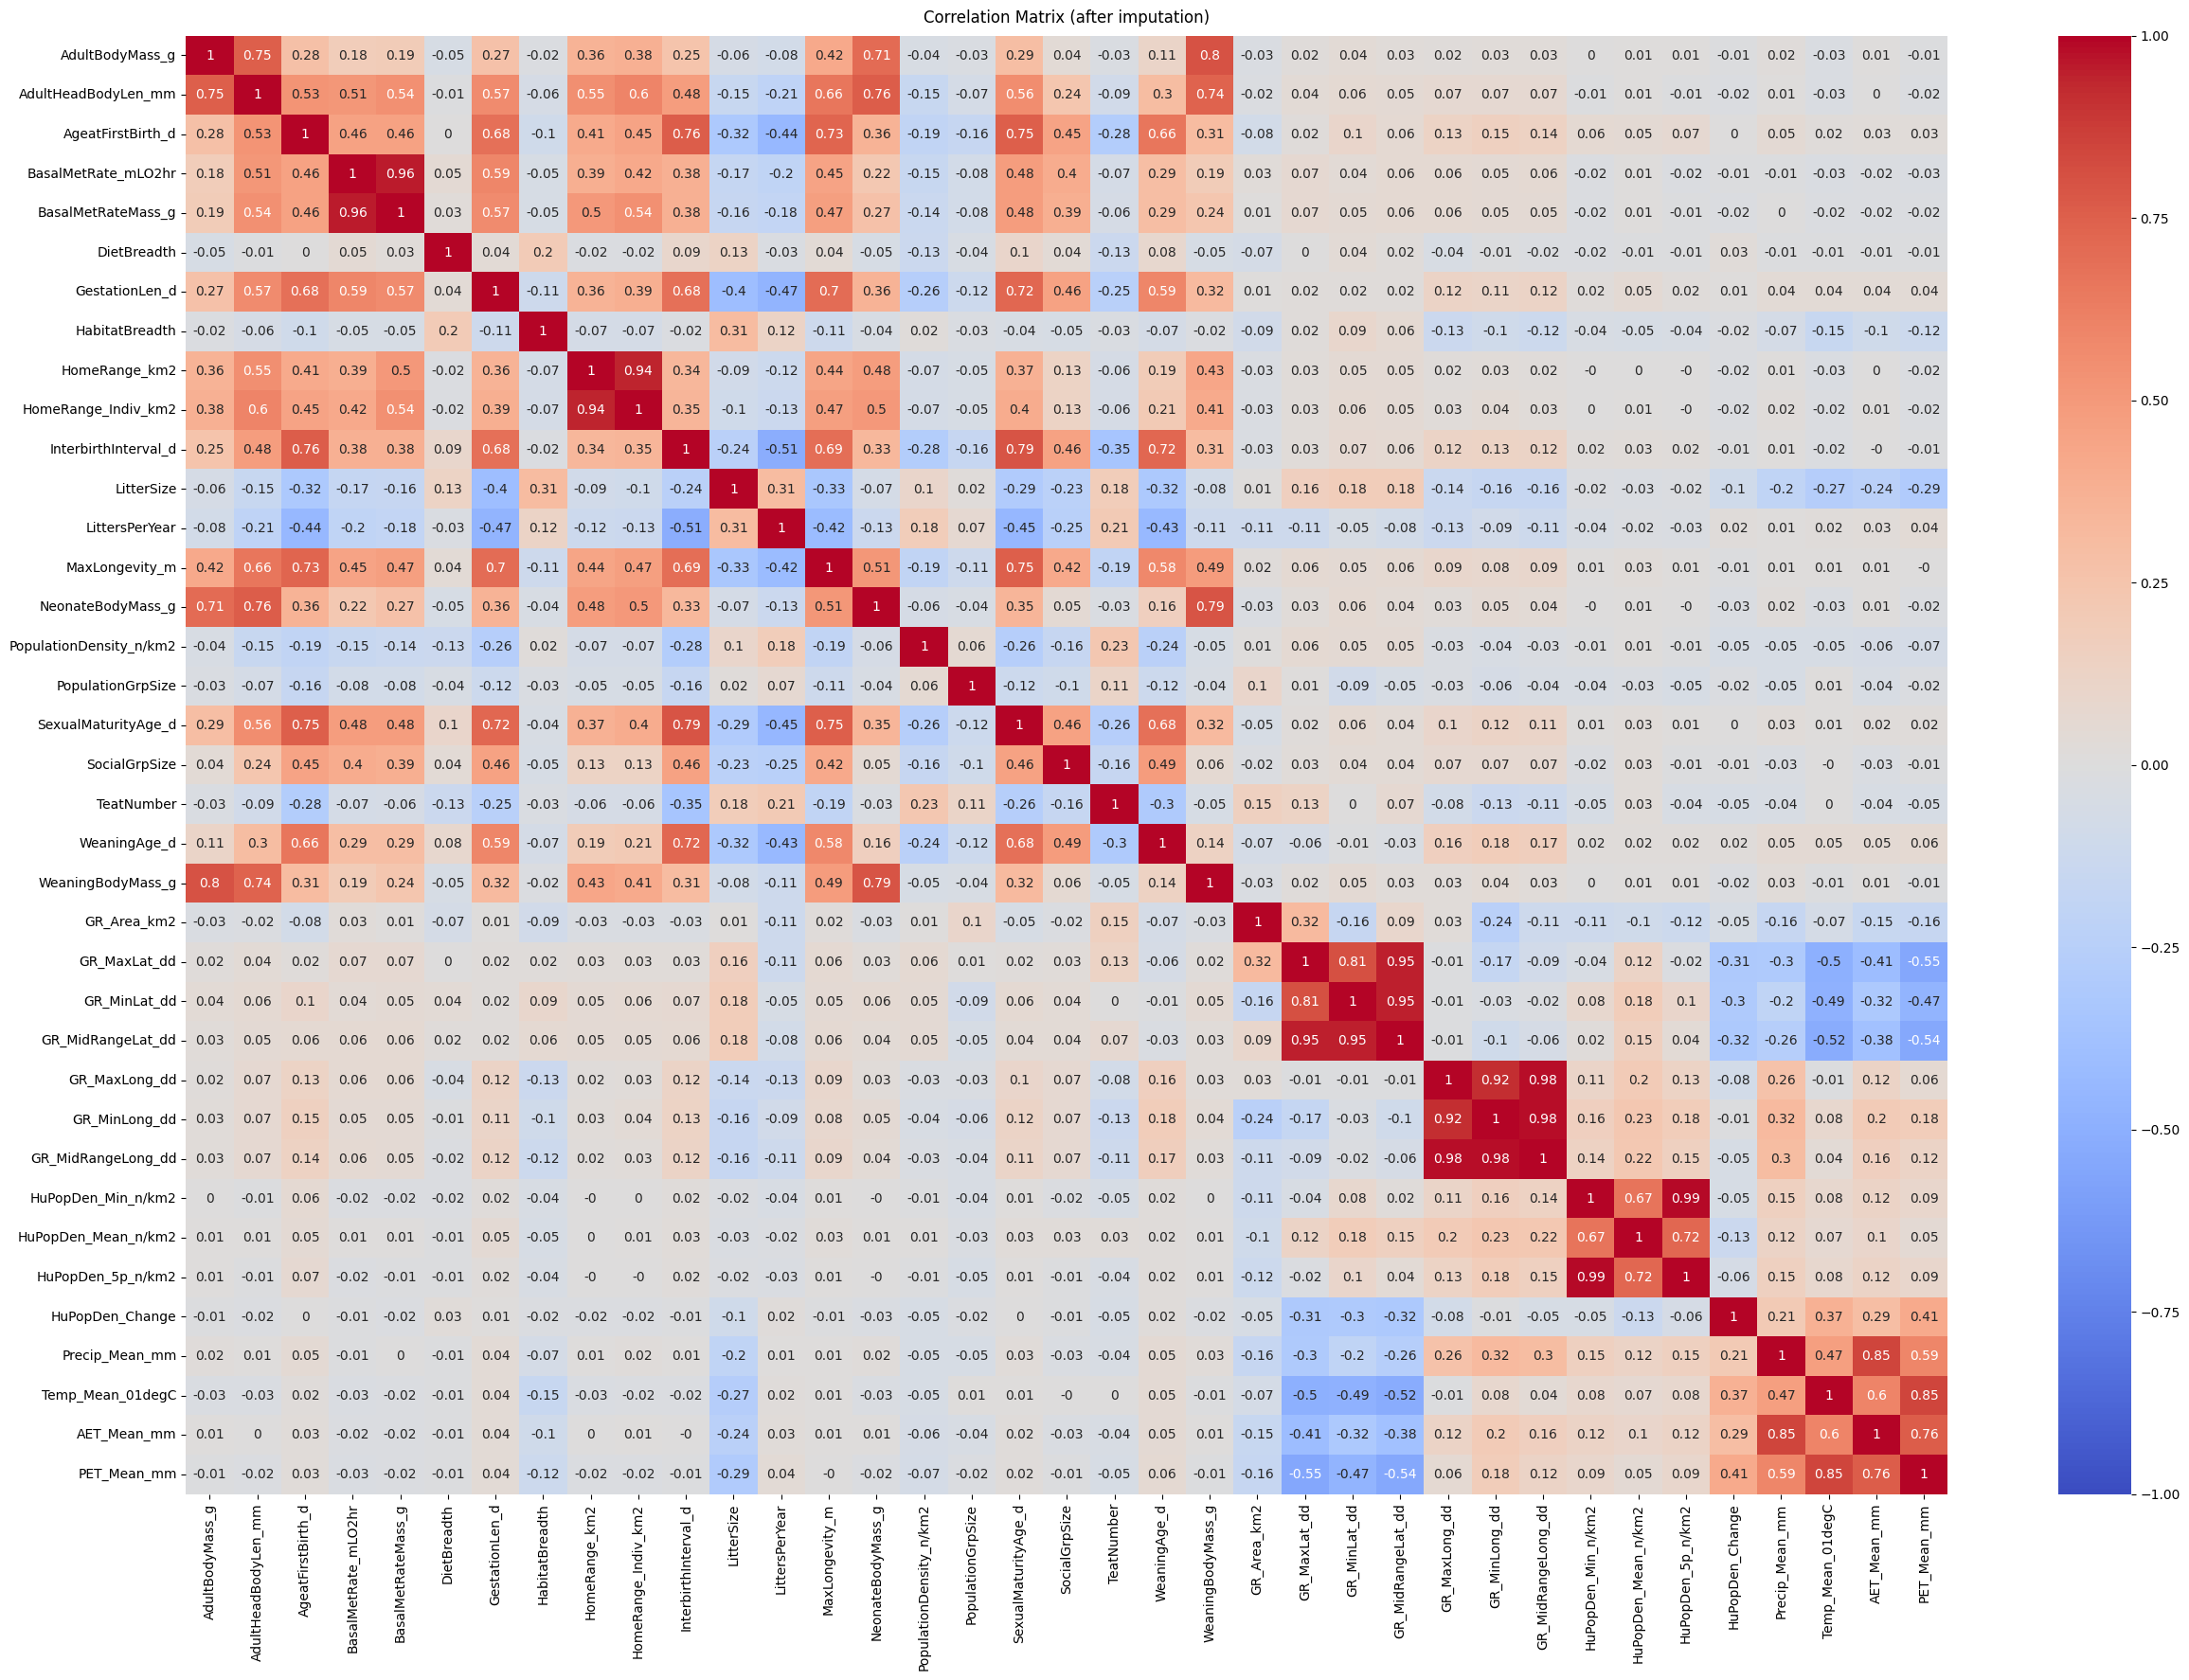

In [25]:
# Examining correlation matrix after imputation

corr_matrix = num_train_df_explore.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', ax=ax, annot=True)
ax.set_title('Correlation Matrix (after imputation)', pad=10)
plt.show()

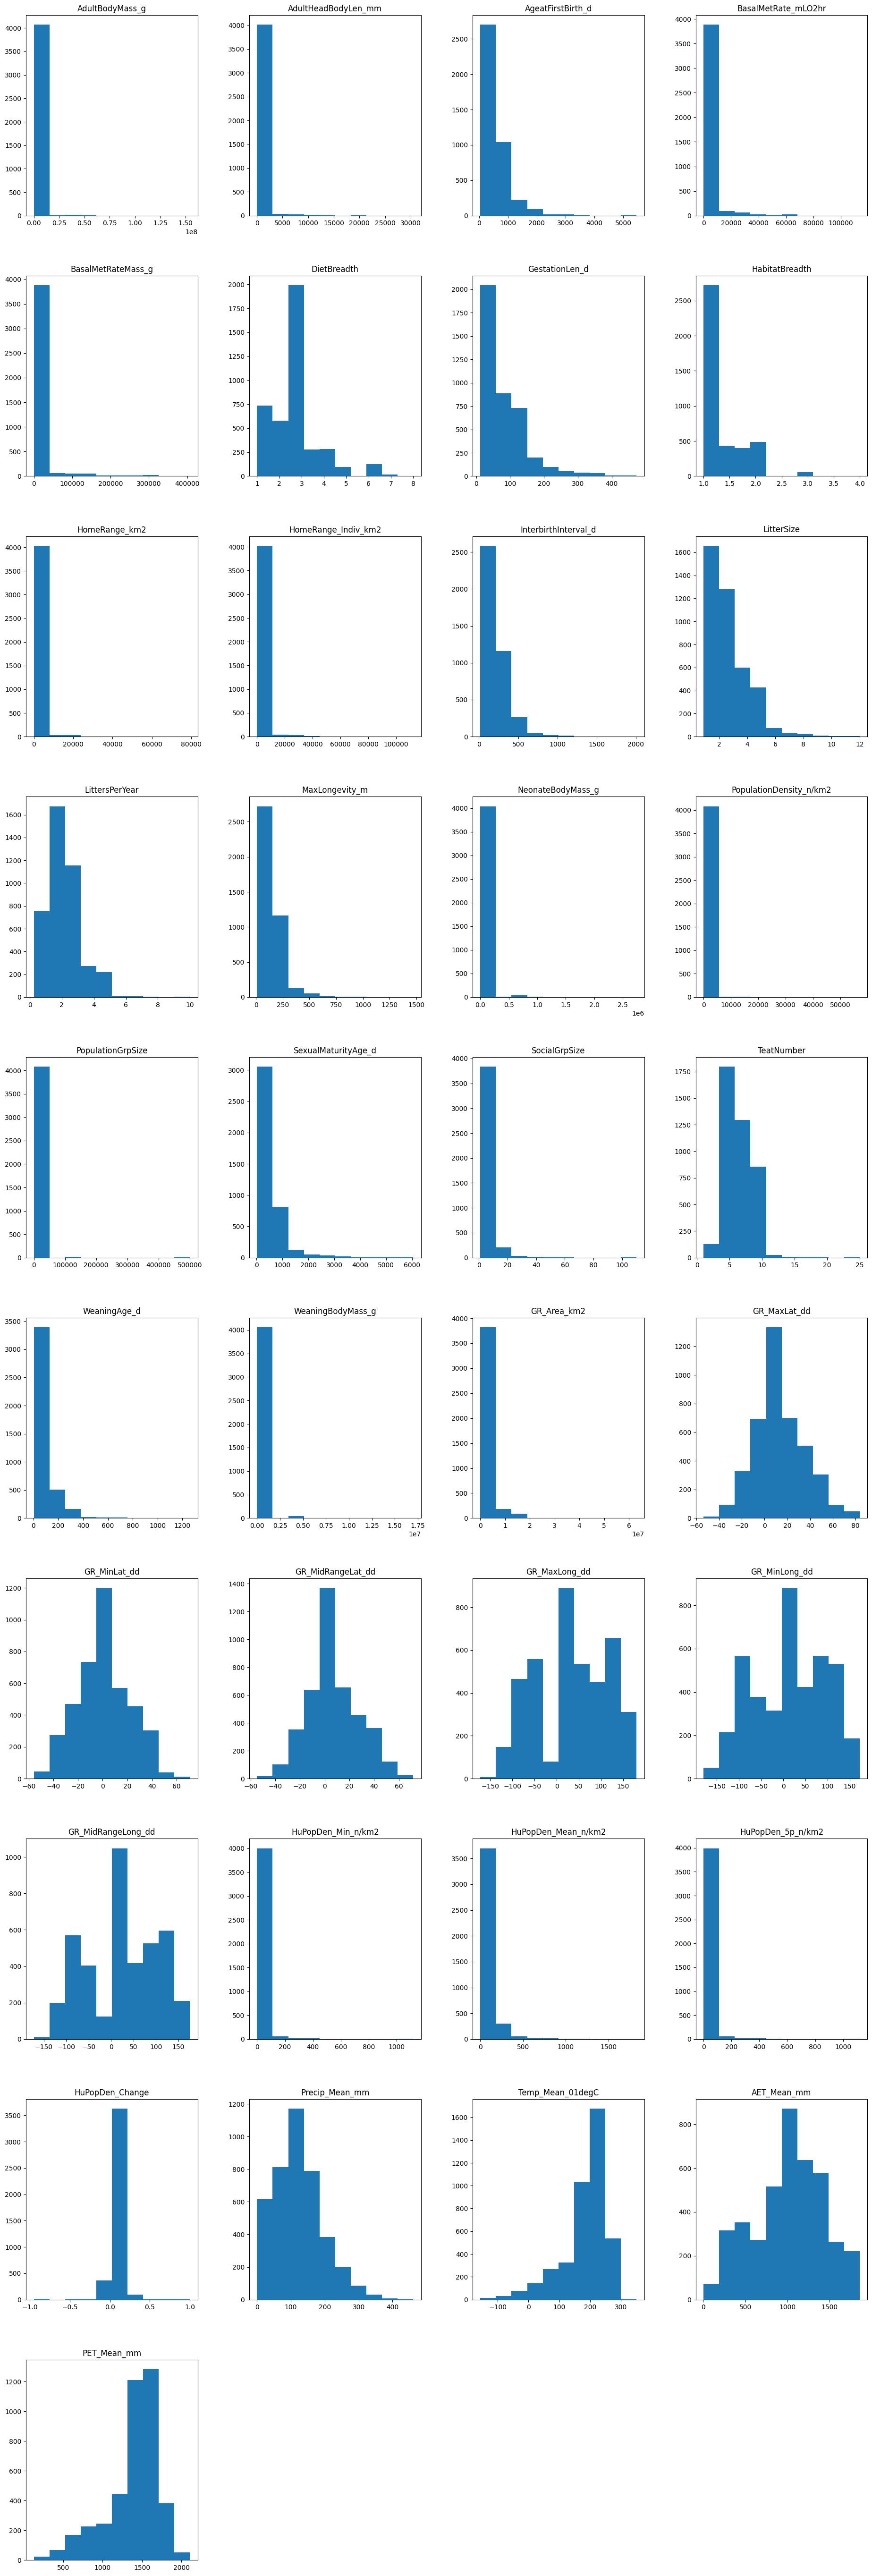

In [26]:
# Distributions after imputation

num_train_df_explore.hist(figsize=(23, 70), layout=(10, 4), sharex=False, sharey=False, grid=False)

plt.show()

In [27]:
pre_transformed_skews = num_train_df_explore.drop('Order', axis=1).skew()
pre_transformed_skews

AdultBodyMass_g            20.144121
AdultHeadBodyLen_mm         9.215865
AgeatFirstBirth_d           2.499649
BasalMetRate_mLO2hr         5.712706
BasalMetRateMass_g          5.768648
DietBreadth                 0.978422
GestationLen_d              2.207358
HabitatBreadth              1.704241
HomeRange_km2              15.090429
HomeRange_Indiv_km2        13.479898
InterbirthInterval_d        2.354165
LitterSize                  1.379611
LittersPerYear              1.492052
MaxLongevity_m              3.449448
NeonateBodyMass_g          13.772380
PopulationDensity_n/km2    15.272269
PopulationGrpSize          25.202183
SexualMaturityAge_d         3.448894
SocialGrpSize               6.014286
TeatNumber                  0.498637
WeaningAge_d                3.916505
WeaningBodyMass_g          15.071403
GR_Area_km2                 5.634161
GR_MaxLat_dd                0.301547
GR_MinLat_dd                0.093804
GR_MidRangeLat_dd           0.246742
GR_MaxLong_dd              -0.233281
G

Transformations will be applied to skewed features in an effort to have them more closely resemble a normal distribution. Highly-skewed features (those with a skew magnitude greater than or equal to 5) will be log-transformed, while less-skewed features (those with a skew magnitude less than 5 but greater than or equal to 1) will be square-root-transformed. The precise mechanics of the transformation (e.g., whether to add a constant or subtract from a constant) will depend on whether the variable is positively-skewed or negatively-skewed.

In [28]:
pos_skew_log_vars = list((pre_transformed_skews[pre_transformed_skews >= 5]).index)

pos_skew_sqrt_vars = list((pre_transformed_skews[(pre_transformed_skews >= 1) & (pre_transformed_skews < 5)]).index)

neg_skew_sqrt_vars = list((pre_transformed_skews[(pre_transformed_skews <= -1) & (pre_transformed_skews > -5)]).index)

neg_skew_log_vars = list((pre_transformed_skews[pre_transformed_skews <= -5]).index)

In [29]:
print(f'Positively-skewed variables to be log-transformed: {", ".join(pos_skew_log_vars)}', end='\n\n')
print(f'Positively-skewed variables to be square-root-transformed: {", ".join(pos_skew_sqrt_vars)}', end='\n\n')
print(f'Negatively-skewed variables to be square-root-transformed: {", ".join(neg_skew_sqrt_vars)}', end='\n\n')
print(f'Negatively-skewed variables to be log-transformed: {", ".join(neg_skew_log_vars)}')

Positively-skewed variables to be log-transformed: AdultBodyMass_g, AdultHeadBodyLen_mm, BasalMetRate_mLO2hr, BasalMetRateMass_g, HomeRange_km2, HomeRange_Indiv_km2, NeonateBodyMass_g, PopulationDensity_n/km2, PopulationGrpSize, SocialGrpSize, WeaningBodyMass_g, GR_Area_km2, HuPopDen_Min_n/km2, HuPopDen_5p_n/km2

Positively-skewed variables to be square-root-transformed: AgeatFirstBirth_d, GestationLen_d, HabitatBreadth, InterbirthInterval_d, LitterSize, LittersPerYear, MaxLongevity_m, SexualMaturityAge_d, WeaningAge_d, HuPopDen_Mean_n/km2

Negatively-skewed variables to be square-root-transformed: Temp_Mean_01degC, PET_Mean_mm

Negatively-skewed variables to be log-transformed: 


In [30]:
if len(pos_skew_log_vars) != 0:
    for feature in pos_skew_log_vars:
        constant_to_add = 1 - num_train_df_explore[feature].min()
        num_train_df_explore['Log_' + feature] = np.log10(num_train_df_explore[feature] + constant_to_add)
        num_train_df_explore = num_train_df_explore.drop(feature, axis=1)

if len(pos_skew_sqrt_vars) != 0:
    for feature in pos_skew_sqrt_vars:
        constant_to_add = 0 - num_train_df_explore[feature].min()
        num_train_df_explore['Sqrt_' + feature] = np.sqrt(num_train_df_explore[feature] + constant_to_add)
        num_train_df_explore = num_train_df_explore.drop(feature, axis=1)

if len(neg_skew_sqrt_vars) != 0:
    for feature in neg_skew_sqrt_vars:
        constant_to_subtract_from = num_train_df_explore[feature].max() + 1
        num_train_df_explore['Sqrt_' + feature] = np.sqrt(constant_to_subtract_from - num_train_df_explore[feature])
        num_train_df_explore = num_train_df_explore.drop(feature, axis=1)

if len(neg_skew_log_vars) != 0:
    for feature in neg_skew_log_vars:
        constant_to_subtract_from = num_train_df_explore[feature].max() + 1
        num_train_df_explore['Log_' + feature] = np.log10(constant_to_subtract_from - num_train_df_explore[feature])
        num_train_df_explore = num_train_df_explore.drop(feature, axis=1)

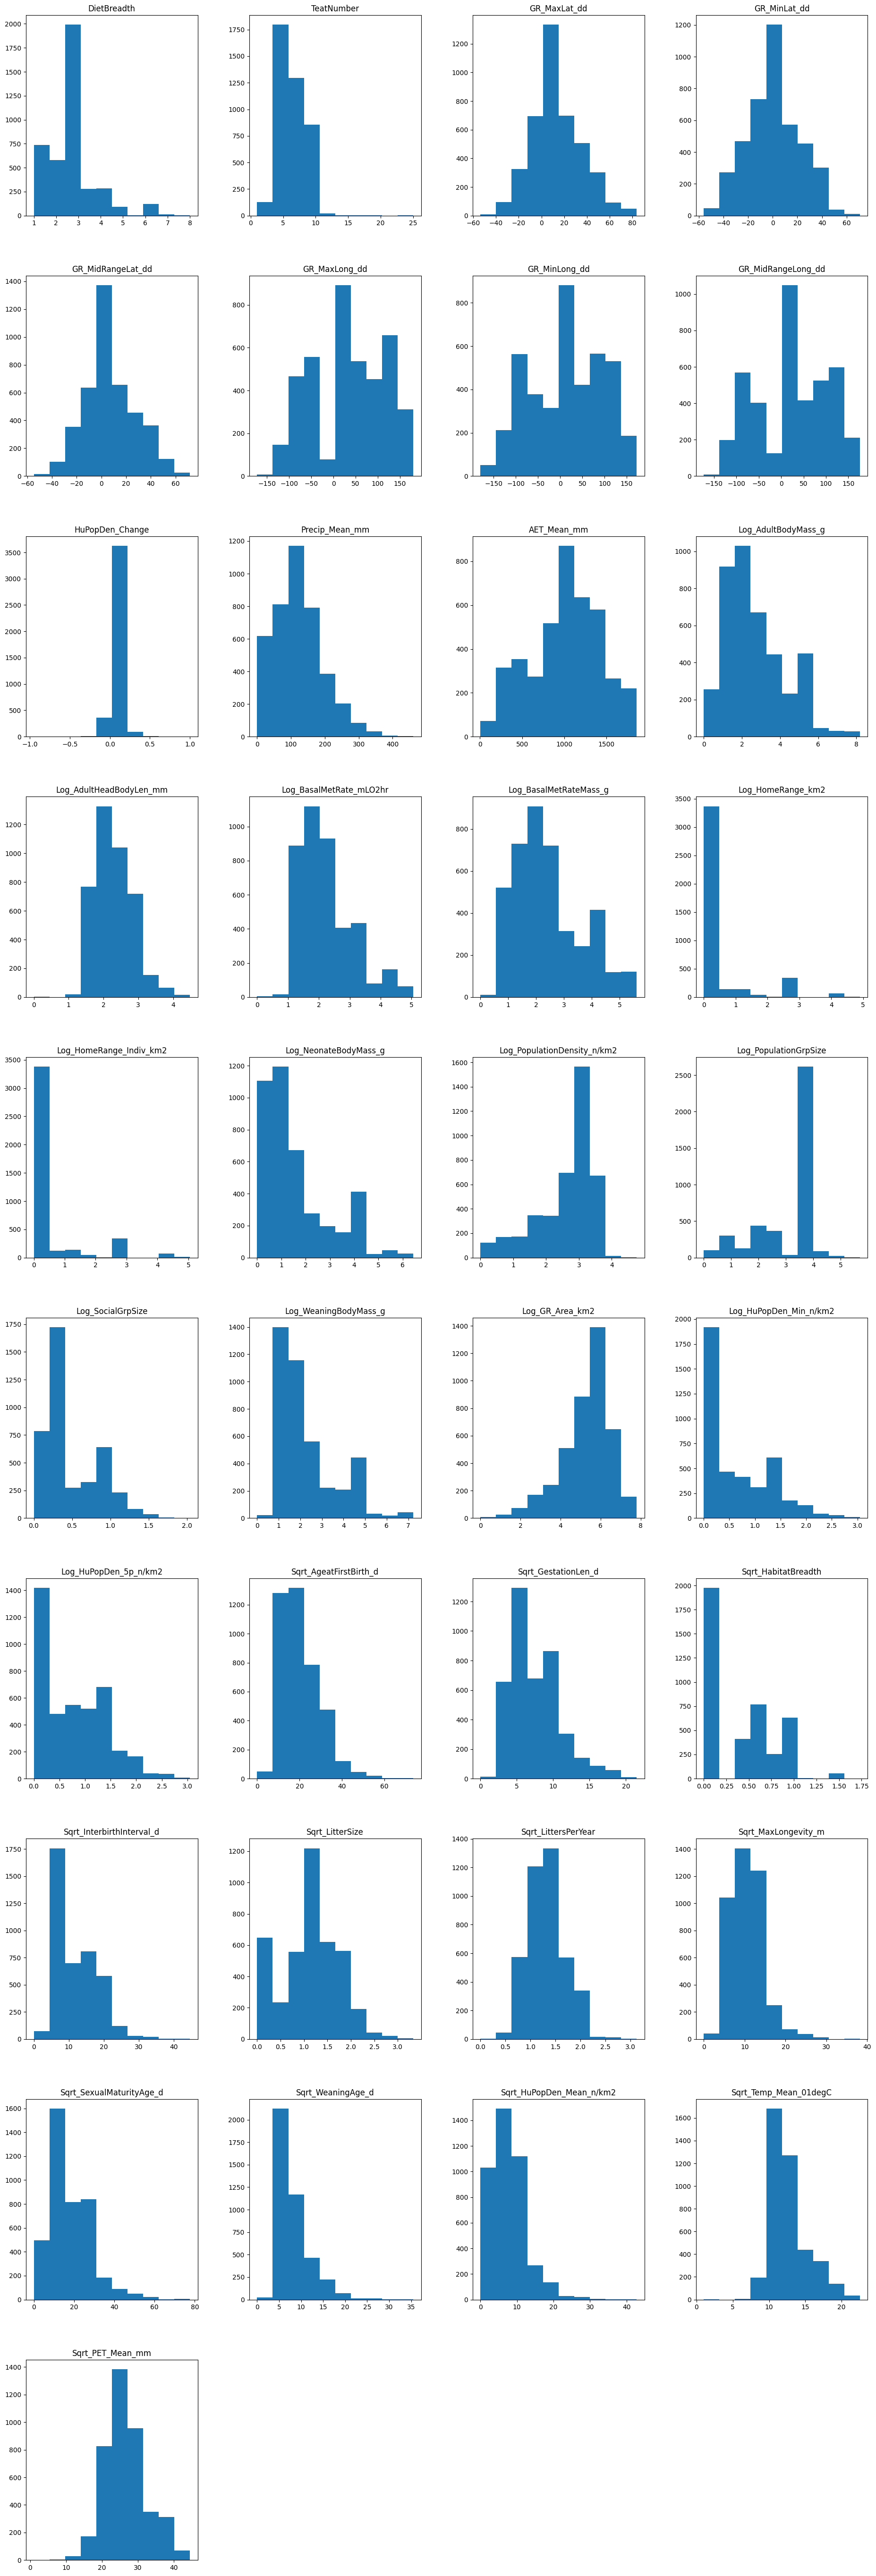

In [31]:
# Distributions after transforming skewed data

num_train_df_explore.hist(figsize=(23, 70), layout=(10, 4), sharex=False, sharey=False, grid=False)

plt.show()

In [32]:
transformed_skews = num_train_df_explore.drop('Order', axis=1).skew()
transformed_skews

DietBreadth                    0.978422
TeatNumber                     0.498637
GR_MaxLat_dd                   0.301547
GR_MinLat_dd                   0.093804
GR_MidRangeLat_dd              0.246742
GR_MaxLong_dd                 -0.233281
GR_MinLong_dd                 -0.173337
GR_MidRangeLong_dd            -0.193167
HuPopDen_Change                0.595530
Precip_Mean_mm                 0.651456
AET_Mean_mm                   -0.224923
Log_AdultBodyMass_g            0.788670
Log_AdultHeadBodyLen_mm        0.525514
Log_BasalMetRate_mLO2hr        0.943160
Log_BasalMetRateMass_g         0.750026
Log_HomeRange_km2              2.558244
Log_HomeRange_Indiv_km2        2.537648
Log_NeonateBodyMass_g          1.284380
Log_PopulationDensity_n/km2   -1.206424
Log_PopulationGrpSize         -1.136180
Log_SocialGrpSize              0.633168
Log_WeaningBodyMass_g          1.271584
Log_GR_Area_km2               -1.004656
Log_HuPopDen_Min_n/km2         0.819561
Log_HuPopDen_5p_n/km2          0.538839


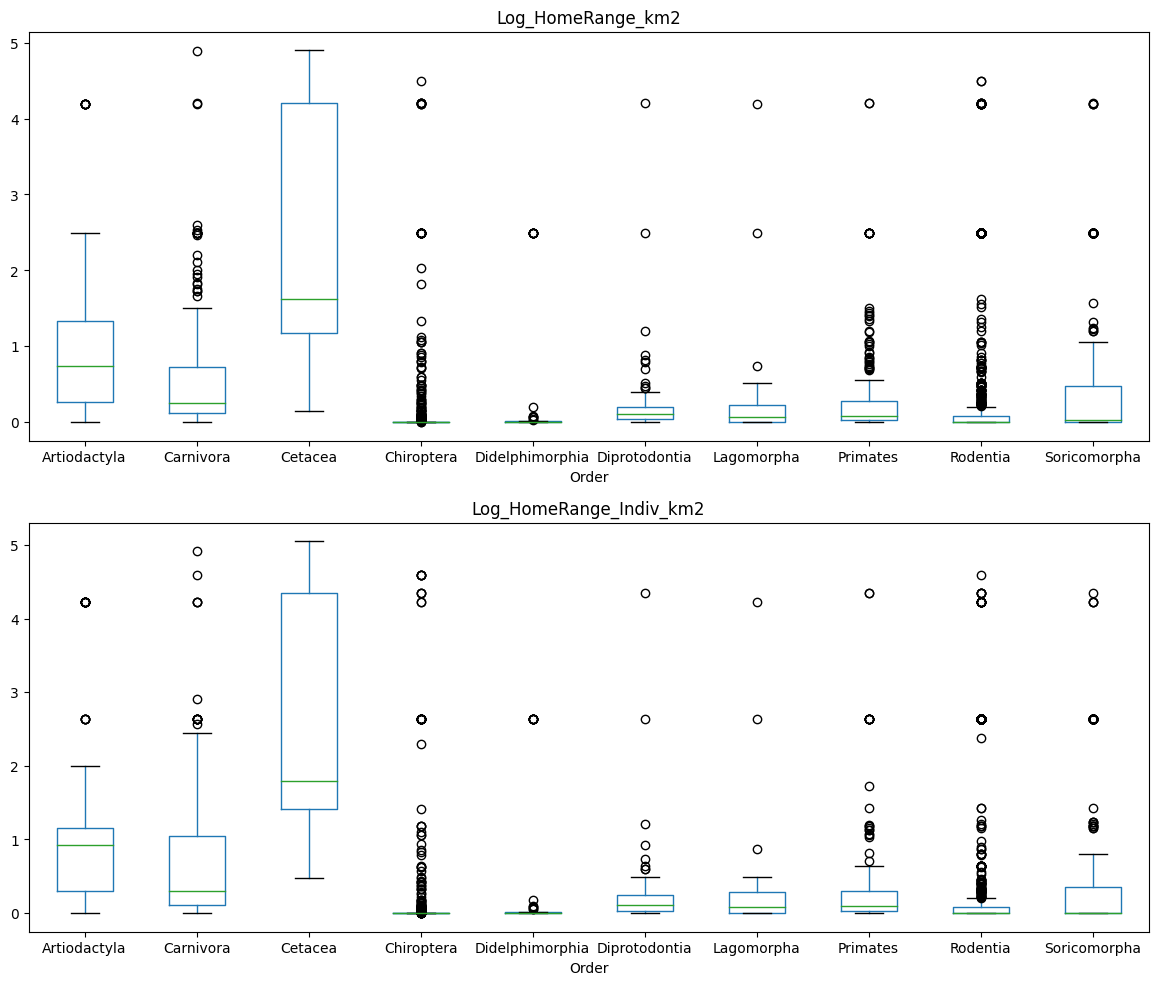

In [33]:
# Cetaceans account for much of the remaining skew in the two most-skewed variables after transformation

fig, axs = plt.subplots(2, 1, figsize=(14, 12))
num_train_df_explore.boxplot(column=['Log_HomeRange_km2', 'Log_HomeRange_Indiv_km2'], by='Order', 
                             sharey=False, sharex=False, ax=axs, grid=False)

fig.suptitle('')
plt.show()

In [34]:
# Standardizing features

standard_scaler = StandardScaler()
stand_num_train_df_explore = standard_scaler.fit_transform(num_train_df_explore.drop('Order', axis=1))

stand_num_train_df_explore = pd.DataFrame(stand_num_train_df_explore, columns=standard_scaler.feature_names_in_)
stand_num_train_df_explore = pd.concat([stand_num_train_df_explore, num_train_df_explore['Order']], axis=1)
stand_num_train_df_explore

DietBreadth  TeatNumber  GR_MaxLat_dd  GR_MinLat_dd  GR_MidRangeLat_dd  \
0        0.317999    0.307649     -0.010303      0.326841           0.165021   
1        1.400402   -1.068448     -0.961559     -0.389972          -0.712078   
2        0.317999   -0.009912      0.748528     -0.328786           0.223986   
3        0.317999    0.836917      0.768040      0.605001           0.721746   
4        0.317999    1.260332     -0.894661     -1.470604          -1.240795   
...           ...         ...           ...           ...                ...   
4098    -0.042802   -0.962594      0.823324      1.058245           0.987579   
4099     1.220002   -1.174301      1.122973      0.677011           0.947286   
4100    -0.223203   -1.174301     -1.495816     -1.464015          -1.555273   
4101    -0.403603   -0.962594     -0.627532     -0.049685          -0.358290   
4102    -0.223203   -0.115765      0.189649      0.774438           0.504560   

      GR_MaxLong_dd  GR_MinLong_dd  GR_MidRangeLong_dd  HuPopDen_Change  \
0          0.482413       0.644400            0.576037        -0.553319   
1          1.013513       1.210110            1.136284        -1.196061   
2          1.094211       0.713506            0.921675         0.028209   
3         -1.570451      -1.489499           -1.562291        -0.430892   
4          0.075636      -0.025279            0.025330         1.252480   
...             ...            ...                 ...              ...   
4098      -0.029661       0.171409            0.073163        -0.277858   
4099       0.128346       0.219623            0.177986         1.711581   
4100       1.276315       1.215549            1.272275        -0.277858   
4101       0.028949       0.269938            0.153561         1.252480   
4102      -1.642615      -1.375269           -1.540029        -1.043027   

      Precip_Mean_mm  AET_Mean_mm  Log_AdultBodyMass_g  \
0           1.120176     0.008885             0.201133   
1          -0.186260     0.420444             0.047203   
2           0.425217     0.228542             1.678348   
3          -0.740758    -0.484354            -0.866895   
4          -0.536409    -0.303618            -0.993824   
...              ...          ...                  ...   
4098       -1.738085    -2.394062            -0.194107   
4099       -1.419495    -1.805119            -0.453803   
4100       -1.473045    -1.732086            -0.741982   
4101       -0.864568    -0.098359             0.205378   
4102       -0.086299     0.033622            -0.746510   

      Log_AdultHeadBodyLen_mm  Log_BasalMetRate_mLO2hr  \
0                    0.551253                 0.618770   
1                   -0.095686                -0.310119   
2                    1.965106                 2.732290   
3                   -0.793958                -1.375046   
4                   -1.149944                -1.035944   
...                       ...                      ...   
4098                 0.861204                 0.478684   
4099                -0.426532                -0.486255   
4100                -0.926776                -0.787252   
4101                 0.709462                -0.276840   
4102                -0.562163                -0.787252   

      Log_BasalMetRateMass_g  Log_HomeRange_km2  Log_HomeRange_Indiv_km2  \
0                   0.519217          -0.253271                -0.243955   
1                  -0.320784          -0.388507                -0.405797   
2                   2.467177           1.263081                 1.104036   
3                  -1.229076          -0.462258                -0.455460   
4                  -1.126984          -0.462862                -0.455993   
...                      ...                ...                      ...   
4098                0.412847           0.476188                -0.418868   
4099               -0.514782          -0.462212                -0.455404   
4100               -0.772502          -0.462876                -0.

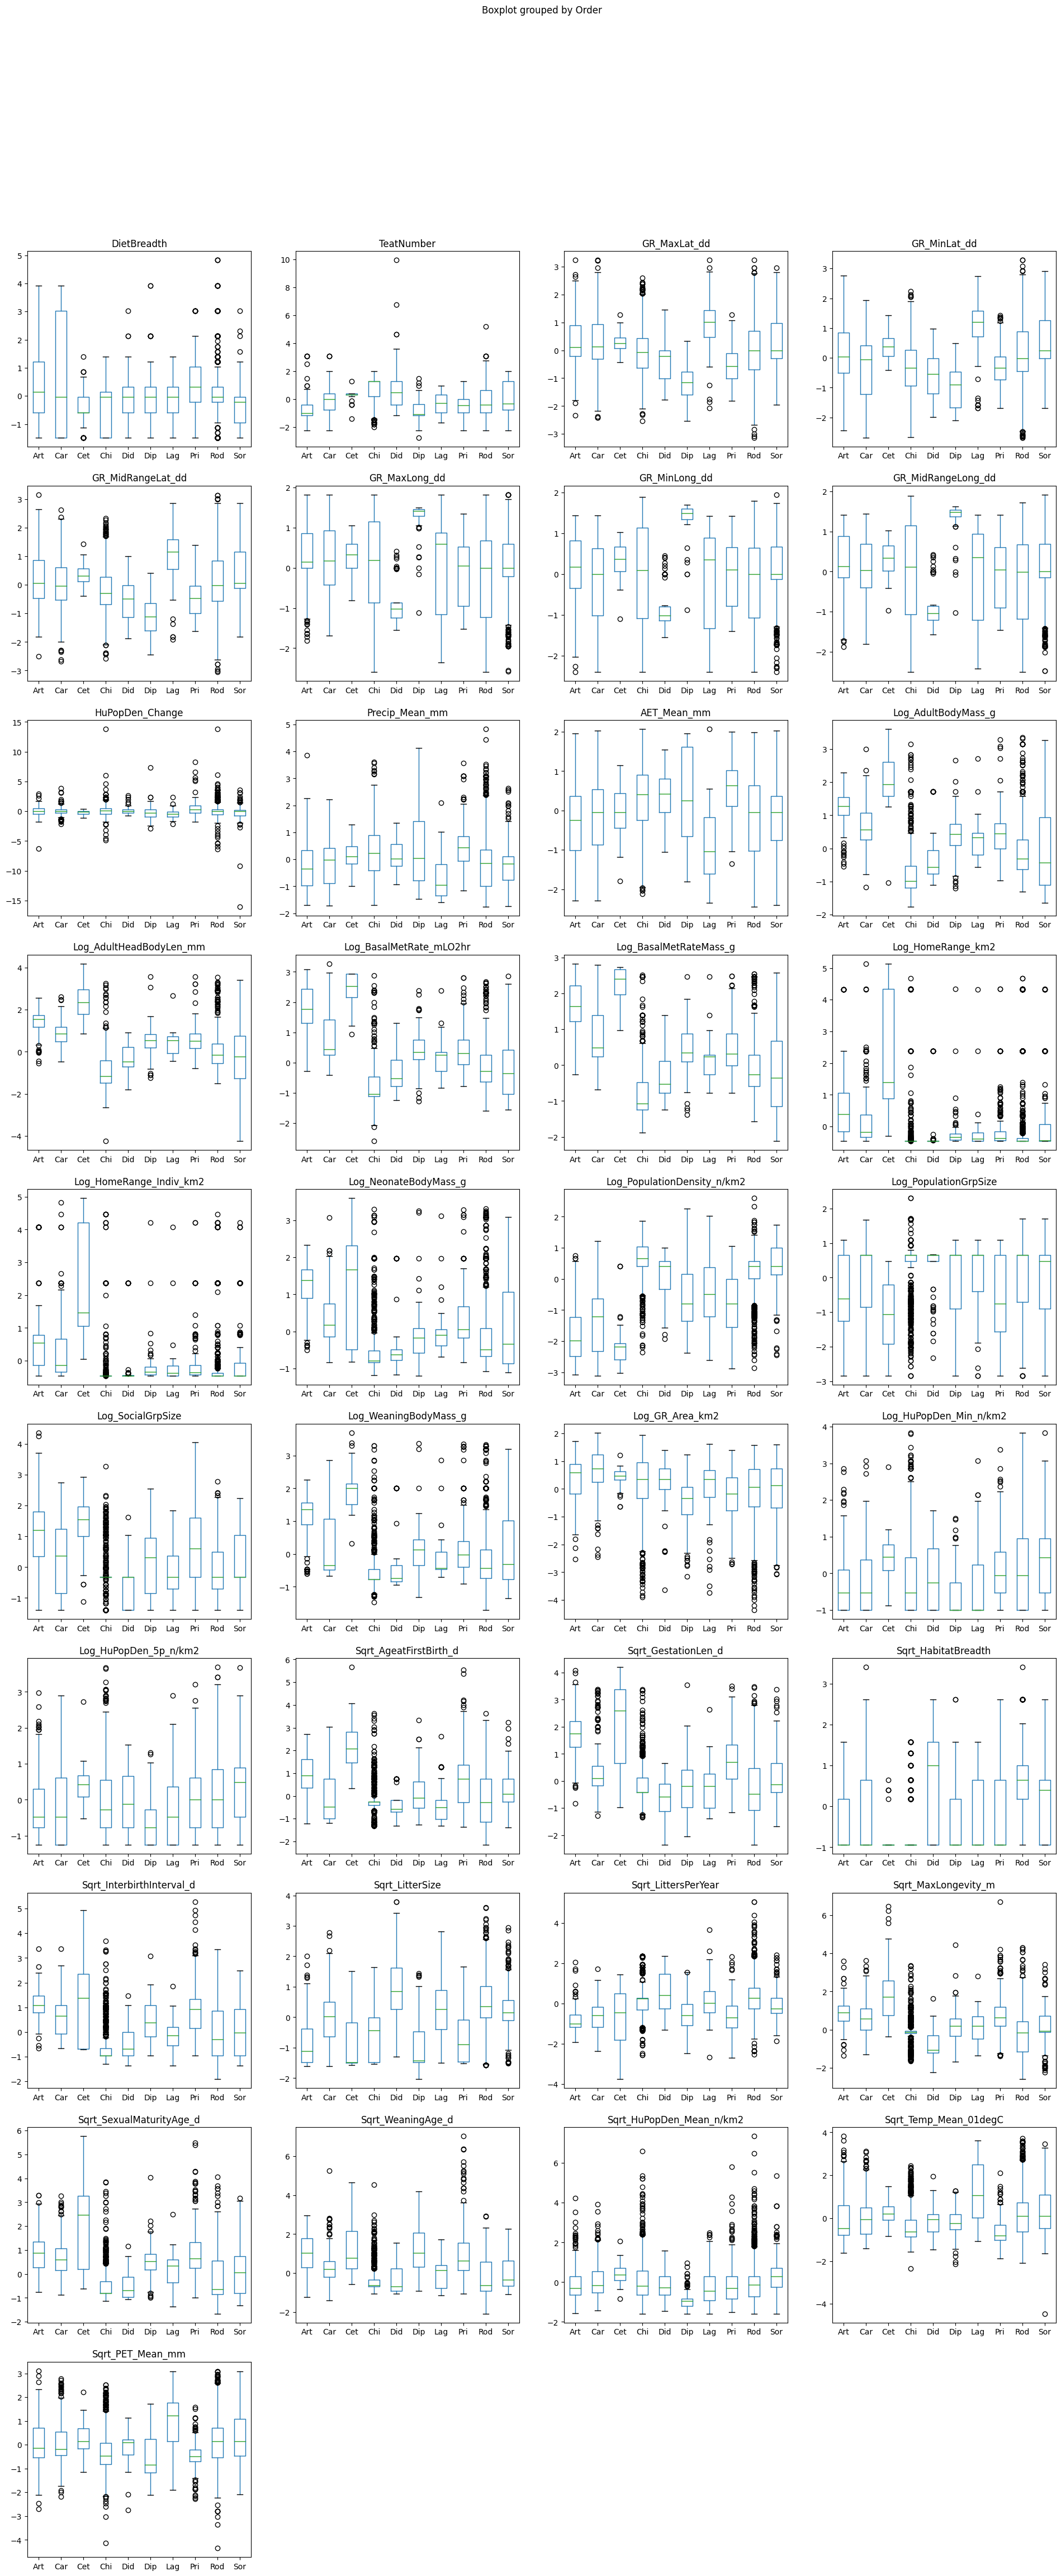

In [35]:
axs = stand_num_train_df_explore.boxplot(column=list(stand_num_train_df_explore.columns[:-1]), by='Order', 
                                         figsize=(23, 55), layout=(10, 4), sharex=False, sharey=False, grid=False)

for ax in axs.ravel():
    xticklabels = ax.get_xticklabels()
    xticklabels_truncated = [i.get_text()[:3] for i in xticklabels]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xticklabels_truncated)
    ax.set_xlabel('')

plt.show()

In [36]:
# At least 95 percent of the variance in the numeric data is explained by the first 19 principle components

pca = PCA(n_components=0.95)
pca_num_train_df_explore = pca.fit_transform(stand_num_train_df_explore.drop('Order', axis=1))
pca_num_train_df_explore.shape

(4103, 19)

In [37]:
# Cumulative percent of variance explained by consecutive principal components

for ind, val in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    print(f'Up to and including PC{ind+1}: {val:.1%} of variance explained')

Up to and including PC1: 32.2% of variance explained
Up to and including PC2: 45.8% of variance explained
Up to and including PC3: 55.3% of variance explained
Up to and including PC4: 61.7% of variance explained
Up to and including PC5: 67.0% of variance explained
Up to and including PC6: 71.7% of variance explained
Up to and including PC7: 75.3% of variance explained
Up to and including PC8: 78.0% of variance explained
Up to and including PC9: 80.4% of variance explained
Up to and including PC10: 82.5% of variance explained
Up to and including PC11: 84.4% of variance explained
Up to and including PC12: 86.2% of variance explained
Up to and including PC13: 88.0% of variance explained
Up to and including PC14: 89.5% of variance explained
Up to and including PC15: 91.0% of variance explained
Up to and including PC16: 92.3% of variance explained
Up to and including PC17: 93.4% of variance explained
Up to and including PC18: 94.3% of variance explained
Up to and including PC19: 95.1% of va

#### Categorical data

In [38]:
cat_train_df_explore

ActivityCycle  Terrestriality  TrophicLevel         Order
0               3.0             2.0           NaN      Primates
1               NaN             NaN           NaN    Chiroptera
2               2.0             NaN           1.0  Artiodactyla
3               NaN             2.0           2.0    Chiroptera
4               NaN             2.0           NaN    Chiroptera
...             ...             ...           ...           ...
4098            NaN             NaN           NaN  Soricomorpha
4099            NaN             NaN           2.0      Rodentia
4100            NaN             NaN           NaN      Rodentia
4101            NaN             NaN           NaN      Rodentia
4102            NaN             NaN           NaN      Rodentia

[4103 rows x 4 columns]

In [39]:
# Converting the binary Terrestriality feature into "AboveGround" dummy variable

cat_train_df_explore['AboveGround'] = cat_train_df_explore['Terrestriality'].map({1: 0, 2: 1})
cat_train_df_explore = cat_train_df_explore.drop('Terrestriality', axis=1)

In [40]:
cat_train_df_explore.groupby('Order').count()

ActivityCycle  TrophicLevel  AboveGround
Order                                                    
Artiodactyla                97           131          113
Carnivora                  165           180          198
Cetacea                      2            41            0
Chiroptera                  51           362          706
Didelphimorphia             52            33           41
Diprotodontia               72            69           91
Lagomorpha                  29            32           38
Primates                   197           140          120
Rodentia                   434           499          565
Soricomorpha                43            76           68

In [41]:
# Distributions of categorical variables by label

for feature in cat_train_df_explore.drop('Order', axis=1).columns:
    print(pd.crosstab(cat_train_df_explore['Order'], cat_train_df_explore[feature]), end='\n\n')

ActivityCycle    1.0  2.0  3.0
Order                         
Artiodactyla       7   65   25
Carnivora         76   66   23
Cetacea            0    1    1
Chiroptera        43    7    1
Didelphimorphia   48    3    1
Diprotodontia     58   13    1
Lagomorpha        16    9    4
Primates          31   14  152
Rodentia         261   56  117
Soricomorpha       1   40    2

TrophicLevel     1.0  2.0  3.0
Order                         
Artiodactyla     107   24    0
Carnivora          6   89   85
Cetacea            0    2   39
Chiroptera        89   50  223
Didelphimorphia    0   18   15
Diprotodontia     47   22    0
Lagomorpha        32    0    0
Primates          48   92    0
Rodentia         245  215   39
Soricomorpha       0   27   49

AboveGround      0.0  1.0
Order                    
Artiodactyla     112    1
Carnivora        184   14
Chiroptera         0  706
Didelphimorphia   12   29
Diprotodontia     41   50
Lagomorpha        37    1
Primates           2  118
Rodentia         326

In [42]:
# Imputing missing categorical values with most-frequent value for its respect feature

simple_imputer = SimpleImputer(strategy='most_frequent')
imputed_cat_features = simple_imputer.fit_transform(cat_train_df_explore.drop('Order', axis=1))
imputed_cat_features_df = pd.DataFrame(imputed_cat_features, columns=simple_imputer.feature_names_in_)
cat_train_df_explore = pd.concat([imputed_cat_features_df, cat_train_df_explore['Order']], axis=1)
cat_train_df_explore

ActivityCycle  TrophicLevel  AboveGround         Order
0               3.0           1.0          1.0      Primates
1               1.0           1.0          1.0    Chiroptera
2               2.0           1.0          1.0  Artiodactyla
3               1.0           2.0          1.0    Chiroptera
4               1.0           1.0          1.0    Chiroptera
...             ...           ...          ...           ...
4098            1.0           1.0          1.0  Soricomorpha
4099            1.0           2.0          1.0      Rodentia
4100            1.0           1.0          1.0      Rodentia
4101            1.0           1.0          1.0      Rodentia
4102            1.0           1.0          1.0      Rodentia

[4103 rows x 4 columns]

In [43]:
# Confirming all missing categorical values have been imputed

cat_train_df_explore.notna().sum(axis=0) / len(cat_train_df_explore)

ActivityCycle    1.0
TrophicLevel     1.0
AboveGround      1.0
Order            1.0
dtype: float64

In [44]:
# Distributions of categorical variables by label after imputation

for feature in cat_train_df_explore.drop('Order', axis=1).columns:
    print(pd.crosstab(cat_train_df_explore['Order'], cat_train_df_explore[feature]), end='\n\n')

ActivityCycle     1.0  2.0  3.0
Order                          
Artiodactyla      102   65   25
Carnivora         140   66   23
Cetacea            65    1    1
Chiroptera        885    7    1
Didelphimorphia    66    3    1
Diprotodontia     100   13    1
Lagomorpha         61    9    4
Primates          135   14  152
Rodentia         1648   56  117
Soricomorpha      300   40    2

TrophicLevel      1.0  2.0  3.0
Order                          
Artiodactyla      168   24    0
Carnivora          55   89   85
Cetacea            26    2   39
Chiroptera        620   50  223
Didelphimorphia    37   18   15
Diprotodontia      92   22    0
Lagomorpha         74    0    0
Primates          209   92    0
Rodentia         1567  215   39
Soricomorpha      266   27   49

AboveGround      0.0   1.0
Order                     
Artiodactyla     112    80
Carnivora        184    45
Cetacea            0    67
Chiroptera         0   893
Didelphimorphia   12    58
Diprotodontia     41    73
Lagomorpha    

In [45]:
# One-hot encoding ActivityCycle and TrophicLevel

ohe = OneHotEncoder()
ohe_cat_features = ohe.fit_transform(cat_train_df_explore[['ActivityCycle', 'TrophicLevel']])
ohe_cat_features_df = pd.DataFrame.sparse.from_spmatrix(ohe_cat_features, columns=ohe.get_feature_names_out())
cat_train_df_explore = pd.concat([ohe_cat_features_df, cat_train_df_explore[['AboveGround', 'Order']]], axis=1)
cat_train_df_explore

ActivityCycle_1.0  ActivityCycle_2.0  ActivityCycle_3.0  \
0                   0.0                0.0                1.0   
1                   1.0                0.0                0.0   
2                   0.0                1.0                0.0   
3                   1.0                0.0                0.0   
4                   1.0                0.0                0.0   
...                 ...                ...                ...   
4098                1.0                0.0                0.0   
4099                1.0                0.0                0.0   
4100                1.0                0.0                0.0   
4101                1.0                0.0                0.0   
4102                1.0                0.0                0.0   

      TrophicLevel_1.0  TrophicLevel_2.0  TrophicLevel_3.0  AboveGround  \
0                  1.0               0.0               0.0          1.0   
1                  1.0               0.0               0.0          1.0   
2                  1.0               0.0               0.0          1.0   
3                  0.0               1.0               0.0          1.0   
4                  1.0               0.0               0.0          1.0   
...                ...               ...               ...          ...   
4098               1.0               0.0               0.0          1.0   
4099               0.0               1.0               0.0          1.0   
4100               1.0               0.0               0.0          1.0   
4101               1.0               0.0               0.0          1.0   
4102               1.0               0.0               0.0          1.0   

             Order  
0         Primates  
1       Chiroptera  
2     Artiodactyla  
3       Chiroptera  
4       Chiroptera  
...            ...  
4098  Soricomorpha  
4099      Rodentia  
4100      Rodentia  
4101      Rodentia  
4102      Rodentia  

[4103 rows x 8 columns]

## Preprocessing, Model Selection, and Hyperparameter Tuning

In [46]:
X_train

ActivityCycle  AdultBodyMass_g  AdultForearmLen_mm  AdultHeadBodyLen_mm  \
11              3.0           992.40                 NaN                  NaN   
4184            NaN              NaN                 NaN                  NaN   
3974            2.0        177522.90                 NaN              2040.00   
2110            NaN            24.26               56.78                  NaN   
2626            NaN            15.88               57.83                  NaN   
...             ...              ...                 ...                  ...   
276             NaN              NaN                 NaN                  NaN   
509             NaN           100.36                 NaN               137.50   
3904            NaN            37.09                 NaN                88.26   
1537            NaN              NaN                 NaN                  NaN   
2436            NaN            36.52                 NaN               121.05   

      AgeatEyeOpening_d  AgeatFirstBirth_d  BasalMetRate_mLO2hr  \
11                  NaN                NaN                  NaN   
4184                NaN                NaN                  NaN   
3974                NaN              788.4                  NaN   
2110                NaN                NaN                  NaN   
2626                NaN                NaN                  NaN   
...                 ...                ...                  ...   
276                 NaN                NaN                  NaN   
509                 NaN                NaN                  NaN   
3904                NaN                NaN                  NaN   
1537                NaN                NaN                  NaN   
2436                NaN                NaN                  NaN   

      BasalMetRateMass_g  DietBreadth  DispersalAge_d  GestationLen_d  \
11                   NaN          NaN             NaN             NaN   
4184                 NaN          NaN             NaN             NaN   
3974                 NaN          3.0             NaN          246.00   
2110                 NaN          3.0             NaN          121.66   
2626                 NaN          NaN             NaN             NaN   
...                  ...          ...             ...             ...   
276                  NaN          NaN             NaN             NaN   
509                  NaN          4.0             NaN           25.00   
3904                 NaN          NaN             NaN           28.96   
1537                 NaN          NaN             NaN             NaN   
2436                 NaN          NaN             NaN             NaN   

      HabitatBreadth  HomeRange_km2  HomeRange_Indiv_km2  \
11               1.0            NaN                  NaN   
4184             NaN            NaN                  NaN   
3974             NaN            NaN                  NaN   
2110             1.0            NaN                  NaN   
2626             1.0            NaN                  NaN   
...              ...            ...                  ...   
276              NaN            NaN                  NaN   
509              NaN            NaN                  NaN   
3904             NaN            NaN                  NaN   
1537             NaN            NaN                  NaN   
2436             NaN            NaN                  NaN   

      InterbirthInterval_d  LitterSize  LittersPerYear  MaxLongevity_m  \
11                     NaN        1.02             NaN             NaN   
4184                   NaN         NaN             NaN             NaN   
3974                   NaN        1.00             NaN          317.04   
2110                   NaN        1.00            1.00             NaN   
2626                   NaN         NaN             NaN             NaN   
...                    ...         ...             ...             ...   
276                    NaN         NaN             NaN             NaN   
509                    NaN        4.99

In [47]:
y_train

11          Primates
4184      Chiroptera
3974    Artiodactyla
2110      Chiroptera
2626      Chiroptera
            ...     
276     Soricomorpha
509         Rodentia
3904        Rodentia
1537        Rodentia
2436        Rodentia
Name: Order, Length: 4103, dtype: object

In [48]:
class SkewTransformer(BaseEstimator, TransformerMixin):
    """
    Apply a positive-skew log transformation to features with a skew greater than
    or equal to self.log_thresh_abs; apply a positive-skew square-root transformation 
    to features with a skew greater than or equal to self.sqrt_thresh_abs but less than 
    self.log_thresh_abs; apply a negative-skew square-root transformation to features
    with a skew less than or equal to -(self.sqrt_thresh_abs) but greater than
    -(self.log_thresh_abs); and apply a negative-skew log transformation to features
    with a skew less than or equal to -(self.log_thresh_abs).
    """
    def __init__(self, sqrt_thresh_abs=1, log_thresh_abs=5):
        self.sqrt_thresh_abs = sqrt_thresh_abs
        self.log_thresh_abs = log_thresh_abs

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = np.zeros(X.shape)
        feature_skews = skew(X)
        for ind, val in enumerate(feature_skews):
            if val >= self.log_thresh_abs:  # Apply positive-skew log transformation
                feature_minimum = np.amin(X[:, ind])
                constant_to_add = 1 - feature_minimum
                transformed_feature = np.log10(X[:, ind] + constant_to_add)
                X_transformed[:, ind] = transformed_feature
            elif val >= self.sqrt_thresh_abs and val < self.log_thresh_abs:  # Apply positive-skew sqrt transformation
                feature_minimum = np.amin(X[:, ind])
                constant_to_add = 0 - feature_minimum
                transformed_feature = np.sqrt(X[:, ind] + constant_to_add)
                X_transformed[:, ind] = transformed_feature
            elif val <= -self.sqrt_thresh_abs and val > -self.log_thresh_abs:  # Apply negative-skew sqrt transformation
                feature_maximum = np.amax(X[:, ind])
                constant_to_subtract_from = feature_maximum + 1
                transformed_feature = np.sqrt(constant_to_subtract_from - X[:, ind])
                X_transformed[:, ind] = transformed_feature
            elif val <= -self.log_thresh_abs:  # Apply negative-skew log transformation
                feature_maximum = np.amax(X[:, ind])
                constant_to_subtract_from = feature_maximum + 1
                transformed_feature = np.log10(constant_to_subtract_from - X[:, ind])
                X_transformed[:, ind] = transformed_feature
            else:  # Apply no transformation at all; feature is not sufficiently skewed
                X_transformed[:, ind] = X[:, ind]
        return X_transformed

In [49]:
def terrestrial_to_above_ground_transformer(X):
    X[X == 1] = 0
    X[X == 2] = 1
    return X

In [50]:
num_pipe = Pipeline([
                        ('imputer', KNNImputer(n_neighbors=5)),
                        ('handle_skewness', SkewTransformer()),
                        ('scaler', StandardScaler()),
                        ('reduce_dim', 'passthrough')                          
                    ])

In [51]:
ct1 = ColumnTransformer([
                        ('num_pipe', num_pipe, numeric_variables),
                        ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical_variables)
                        ], remainder='drop')  # Columns dropped at this step are the five features with insufficient data


ct2 = ColumnTransformer([
                         ('terr_to_above_ground', FunctionTransformer(terrestrial_to_above_ground_transformer), [-2]),
                         ('cat_encoder', OneHotEncoder(), [-3, -1])                                                                                         
                        ], remainder='passthrough')

final_pipe = Pipeline([('ct1', ct1), 
                       ('ct2', ct2),
                       ('clf', SVC())])

In [52]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [ ]:
# Examining performance of various classes of models using grid search cross validation (CV)

param_grid = [{'clf': [SVC()], 'clf__kernel': ['rbf', 'poly', 'sigmoid'], 'clf__C': np.logspace(-3, 2, 6),
               'ct1__num_pipe__reduce_dim': ['passthrough', PCA(0.95)]},
              {'clf': [LinearSVC(dual=False)], 'clf__C': np.logspace(-3, 2, 6), 
               'ct1__num_pipe__reduce_dim': ['passthrough', PCA(0.95)]},
              {'clf': [RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42)], 
               'clf__min_samples_split': [2, 20, 200],
               'ct1__num_pipe__reduce_dim': ['passthrough', PCA(0.95)]},
              {'clf': [HistGradientBoostingClassifier(random_state=42)], 
               'clf__min_samples_leaf': [5, 50, 100, 250],
               'ct1__num_pipe__reduce_dim': ['passthrough', PCA(0.95)]}]


model_type_grid_search = GridSearchCV(final_pipe, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
model_type_grid_search.fit(X_train, y_train_enc)

model_type_cv_results = pd.DataFrame(model_type_grid_search.cv_results_).sort_values('rank_test_score')
model_type_cv_results.to_csv(r'..\cv_output\model_type_grid_search_cv_results.csv', index=False)


In [53]:
model_type_cv_results = pd.read_csv(r'..\cv_output\model_type_grid_search_cv_results.csv')
model_type_cv_results.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      37.060116      0.516083         3.180970        0.071546   
1      29.028239      0.906224         3.118442        0.307277   
2      22.305960      0.805713         3.252139        0.440046   
3      15.249070      0.290031         2.411788        0.083960   
4      14.748376      0.182616         2.774701        0.147768   
5      43.957971      1.063833         3.137493        0.255907   
6      10.649555      0.696485         2.447000        0.160124   
7      11.825992      0.442711         2.951700        0.297823   
8      13.649742      0.529699         2.567142        0.217656   
9      15.696370      0.255540         2.454061        0.064805   

                                           param_clf  param_clf__C  \
0  HistGradientBoostingClassifier(min_samples_lea...           NaN   
1  HistGradientBoostingClassifier(min_samples_lea...           NaN   
2  HistGradientBoostingClassifier(min_samples_lea...           NaN   
3            RandomForestClassifier(random_state=42)           NaN   
4            RandomForestClassifier(random_state=42)           NaN   
5  HistGradientBoostingClassifier(min_samples_lea...           NaN   
6            DecisionTreeClassifier(random_state=42)           NaN   
7            DecisionTreeClassifier(random_state=42)           NaN   
8            RandomForestClassifier(random_state=42)           NaN   
9            RandomForestClassifier(random_state=42)           NaN   

  param_clf__kernel param_ct1__num_pipe__reduce_dim  \
0               NaN                     passthrough   
1               NaN                     passthrough   
2               NaN                     passthrough   
3               NaN                     passthrough   
4               NaN                     passthrough   
5               NaN                     passthrough   
6               NaN                     passthrough   
7               NaN                     passthrough   
8               NaN                     passthrough   
9               NaN          PCA(n_components=0.95)   

   param_clf__min_samples_split  param_clf__min_samples_leaf  \
0                           NaN                         50.0   
1                           NaN                        100.0   
2                           NaN                        250.0   
3                           2.0                          NaN   
4                          20.0                          NaN   
5                           NaN                          5.0   
6                           2.0                          NaN   
7                          20.0                          NaN   
8                         200.0                          NaN   
9                           2.0                          NaN   

                                              params  split0_test_score  \
0  {'clf': HistGradientBoostingClassifier(min_sam...           0.661184   
1  {'clf': HistGradientBoostingClassifier(min_sam...           0.680758   
2  {'clf': HistGradientBoostingClassifier(min_sam...           0.614823   
3  {'clf': RandomForestClassifier(random_state=42...           0.616388   
4  {'clf': RandomForestClassifier(random_state=42...           0.577302   
5  {'clf': HistGradientBoostingClassifier(min_sam...           0.593264   
6  {'clf': DecisionTreeClassifier(random_state=42...           0.351888   
7  {'clf': DecisionTreeClassifier(random_state=42...           0.360168   
8  {'clf': RandomForestClassifier(random_state=42...           0.286065   
9  {'clf': RandomForestClassifier(random_state=42...           0.330227   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.546106           0.596789           0.633586           0.476341   
1           0.502039           0.608742           0.609964           0.475978   
2           0.479726           0.614359           0.633039           0.498688   
3           0.444732           0.

The best-performing models in the grid search were histogram-based gradient boosting classifiers (GBCs) and random forests; both performed optimally when they did not reduce the dimensionality of the numeric features. These findings will serve as the foundation for the upcoming ```RandomizedSearchCV```, where both types of models will be put through 200 iterations of cross validation with randomized hyperparameter settings.

In [ ]:
# Both types of models will randomly vary over imputation strategy and skewness transformation thresholds

possible_num_imputers = [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median'), 
                         KNNImputer(n_neighbors=10), KNNImputer(n_neighbors=100)]


data_prep_param_grid = {'ct1__num_pipe__imputer': possible_num_imputers,
                        'ct1__num_pipe__handle_skewness__sqrt_thresh_abs': randint(1, 4),
                        'ct1__num_pipe__handle_skewness__log_thresh_abs': randint(4, 7)
                        }

In [ ]:
# GBCs in particular will vary over learning rate, maximum number of iterations, minimum leaf size, and L2 regularization

gb_model_params = {'clf': [HistGradientBoostingClassifier(random_state=42)],
                   'clf__learning_rate': np.logspace(-3, 0, 4),
                   'clf__max_iter': [50, 100, 500, 1000, 2000],
                   'clf__min_samples_leaf': [5, 50, 100, 250],
                   'clf__l2_regularization': np.logspace(-3, 2, 6)}

gb_total_params = gb_model_params | data_prep_param_grid
gb_rand_search = RandomizedSearchCV(final_pipe, gb_total_params, n_iter=200, 
                                    scoring='balanced_accuracy', cv=5, random_state=42,
                                    n_jobs=-1)
gb_rand_search.fit(X_train, y_train_enc)

gb_cv_results = pd.DataFrame(gb_rand_search.cv_results_).sort_values('rank_test_score')
gb_cv_results.to_csv(r'..\cv_output\gb_rand_search_cv_results.csv', index=False)

In [ ]:
# Random forests in particular will vary over number of trees, minimum sample size to split an internal node, 
# minimum leaf size, and the number of features to consider when looking for the best split

rf_model_params = {'clf': [RandomForestClassifier(random_state=42, oob_score=True)], 
                   'clf__n_estimators': [50, 100, 150], 
                   'clf__min_samples_split': [10, 100, 500], 
                   'clf__min_samples_leaf': [5, 50, 100, 250], 
                   'clf__max_features': ['sqrt', 10, 20, 30, 44]}

rf_total_params = rf_model_params | data_prep_param_grid
rf_rand_search = RandomizedSearchCV(final_pipe, rf_total_params, n_iter=200, 
                                    scoring='balanced_accuracy', cv=5, random_state=42,
                                    n_jobs=-1)
rf_rand_search.fit(X_train, y_train_enc)

rf_cv_results = pd.DataFrame(rf_rand_search.cv_results_).sort_values('rank_test_score')
rf_cv_results.to_csv(r'..\cv_output\rf_rand_search_cv_results.csv', index=False)

In [54]:
gb_cv_results = pd.read_csv(r'..\cv_output\gb_rand_search_cv_results.csv')
rf_cv_results = pd.read_csv(r'..\cv_output\rf_rand_search_cv_results.csv')

cv_results_total = pd.concat([gb_cv_results, rf_cv_results], axis=0)
cv_results_total = cv_results_total.sort_values('mean_test_score', ascending=False).reset_index(drop=True)
cv_results_total.head(20)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      280.827954      2.728532         4.904358        0.152346   
1      146.299034      1.035005         2.510839        0.153256   
2       52.417478      0.816920         1.380639        0.069920   
3       65.883267      1.389719         2.230150        0.106600   
4      243.729317      4.761018         5.762466        0.261380   
5        5.220228      0.120097         0.148228        0.012939   
6       13.395333      0.236153         0.322996        0.029485   
7        7.995812      0.303519         0.289162        0.018957   
8       89.936240      1.328976         1.463975        0.091838   
9       76.779864      1.434277         1.989296        0.057197   
10      94.436537      3.324221         2.432683        0.124102   
11       7.864014      0.303240         0.177905        0.009530   
12      63.177700      0.845833         1.536734        0.217017   
13     186.706105      2.053871         3.005345        0.117722   
14       7.216571      0.142226         0.256708        0.019296   
15     344.277502      2.614079         7.400787        0.321045   
16     123.421382      3.059062         2.182685        0.112423   
17     152.673942      3.844516         4.724452        0.129196   
18     205.965180      2.928740         4.925488        0.206920   
19     358.831039      2.622424         5.324033        0.280657   

                                            param_clf  \
0   HistGradientBoostingClassifier(l2_regularizati...   
1   HistGradientBoostingClassifier(l2_regularizati...   
2   HistGradientBoostingClassifier(l2_regularizati...   
3   HistGradientBoostingClassifier(l2_regularizati...   
4   HistGradientBoostingClassifier(l2_regularizati...   
5   HistGradientBoostingClassifier(l2_regularizati...   
6   HistGradientBoostingClassifier(l2_regularizati...   
7   HistGradientBoostingClassifier(l2_regularizati...   
8   HistGradientBoostingClassifier(l2_regularizati...   
9   HistGradientBoostingClassifier(l2_regularizati...   
10  HistGradientBoostingClassifier(l2_regularizati...   
11  HistGradientBoostingClassifier(l2_regularizati...   
12  HistGradientBoostingClassifier(l2_regularizati...   
13  HistGradientBoostingClassifier(l2_regularizati...   
14  HistGradientBoostingClassifier(l2_regularizati...   
15  HistGradientBoostingClassifier(l2_regularizati...   
16  HistGradientBoostingClassifier(l2_regularizati...   
17  HistGradientBoostingClassifier(l2_regularizati...   
18  HistGradientBoostingClassifier(l2_regularizati...   
19  HistGradientBoostingClassifier(l2_regularizati...   

    param_clf__l2_regularization  param_clf__learning_rate  \
0                         10.000                      0.01   
1                          1.000                      0.01   
2                        100.000                      0.10   
3                         10.000                      1.00   
4                        100.000                      0.10   
5                         10.000                      1.00   
6                          0.010                      0.10   
7                          0.100                      0.10   
8                         10.000                      0.10   
9                          0.001                      0.10   
10                         0.001                      0.10   
11                       100.000                      1.00   
12                         0.001                      0.10   
13                         0.001                      0.01   
14                         0.010                      0.10   
15                        10.000                      0.10   
16                         0.010                      0.10   
17                       100.000                      1.00   
18                       100.000                      1.00   
19                         0.100                      0.10   

    param_clf__max_iter  param_clf__min_samples_leaf  \
0                2

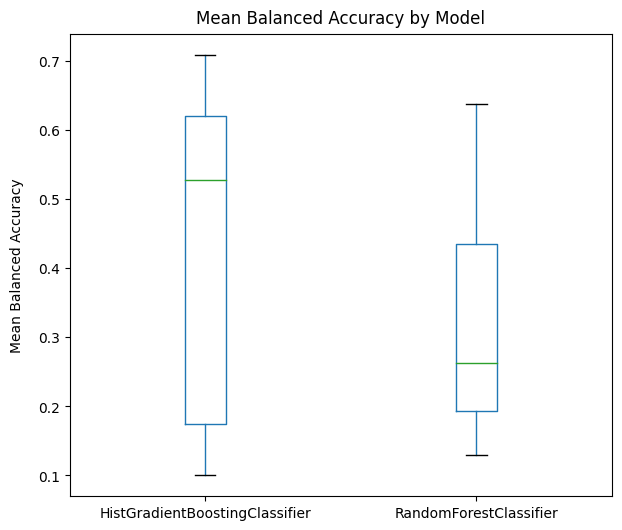

In [55]:
cv_results_total['model_type'] = cv_results_total['param_clf'].str.split('(', expand=True)[0]

model_groupby = cv_results_total.groupby('model_type')
ax = model_groupby.boxplot(column='mean_test_score', subplots=False, grid=False,
                           figsize=(7, 6))

ax.set_xticklabels(model_groupby.groups.keys())
ax.set_ylabel('Mean Balanced Accuracy', labelpad=10)
ax.set_title('Mean Balanced Accuracy by Model', pad=8)
plt.show()

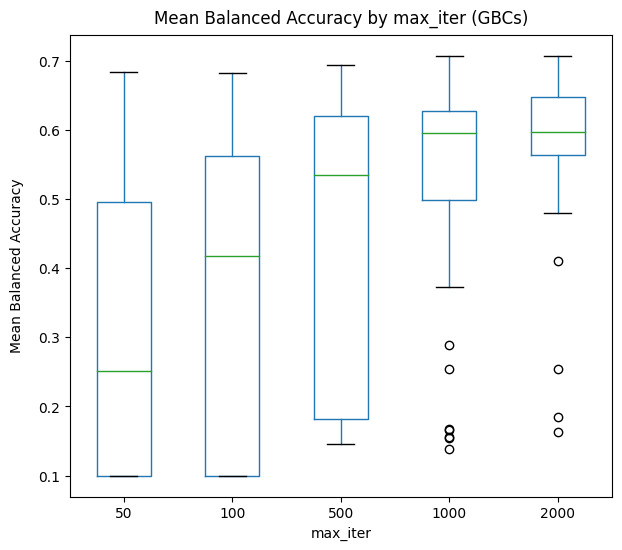

In [56]:
gbcs = model_groupby.get_group('HistGradientBoostingClassifier')
gbcs_max_iter_groupby = gbcs.groupby('param_clf__max_iter')

ax = gbcs_max_iter_groupby.boxplot(column='mean_test_score', subplots=False, grid=False,
                           figsize=(7, 6))

ax.set_xlabel('max_iter')
ax.set_xticklabels([int(x) for x in gbcs_max_iter_groupby.groups.keys()])
ax.set_ylabel('Mean Balanced Accuracy', labelpad=10)
ax.set_title('Mean Balanced Accuracy by max_iter (GBCs)', pad=8)
plt.show()

In [57]:
skew_threshold_params = ['param_ct1__num_pipe__handle_skewness__log_thresh_abs',
                         'param_ct1__num_pipe__handle_skewness__sqrt_thresh_abs']

gbcs[skew_threshold_params + ['mean_test_score']]

param_ct1__num_pipe__handle_skewness__log_thresh_abs  \
0                                                    6      
1                                                    6      
2                                                    4      
3                                                    6      
4                                                    4      
..                                                 ...      
395                                                  4      
396                                                  6      
397                                                  6      
398                                                  4      
399                                                  6      

     param_ct1__num_pipe__handle_skewness__sqrt_thresh_abs  mean_test_score  
0                                                    3             0.707934  
1                                                    2             0.706970  
2                                                    3             0.694311  
3                                                    3             0.687445  
4                                                    1             0.686255  
..                                                 ...                  ...  
395                                                  1             0.100000  
396                                                  3             0.100000  
397                                                  3             0.100000  
398                                                  3             0.100000  
399                                                  1             0.100000  

[200 rows x 3 columns]

Gradient boosting classifiers performed better than random forests, both overall and at the extreme upper edge of performance. Top-performing GBCs tended to use a mean-imputation strategy along with a ```max_iter``` of 500 or greater; ```learning_rate```, ```min_samples_leaf```, and ```l2_regularization``` varied widely across the spectrum of possible values. Precise skewness thresholds for log transformations did not appreciably influence performance, although a skewness threshold of either 2 or 3 for square-root transformations was generally optimal. Further hyperparameter tuning will proceed with the best-performing model from this round of CV&mdash;a GBC that employed a mean-imputation strategy, a learning rate of 0.01, a minimum leaf size of 50, and a maximum of 2000 iterations of the boosting process.

In [58]:
best_estimator_cv_params = eval(cv_results_total.loc[0, 'params'])
best_estimator_cv = clone(final_pipe).set_params(**best_estimator_cv_params)
best_estimator_cv

Pipeline(steps=[('ct1',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('handle_skewness',
                                                                   SkewTransformer(log_thresh_abs=6,
                                                                                   sqrt_thresh_abs=3)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('reduce_dim',
                                                                   'passthrough')]),
                                                  ['AdultBodyMass_g',
                                                   'AdultHeadBodyLen_mm',
                                                   'AgeatFirstBirth_d',
                                                   'BasalMetRate_mLO2hr',
                                                   'BasalMetRateMass_g',
                                                   'Die...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('terr_to_above_ground',
                                                  FunctionTransformer(func=<function terrestrial_to_above_ground_transformer at 0x00000137E87E20D0>),
                                                  [-2]),
                                                 ('cat_encoder',
                                                  OneHotEncoder(),
                                                  [-3, -1])])),
                ('clf',
                 HistGradientBoostingClassifier(l2_regularization=10.0,
                                                learning_rate=0.01,
                                                max_iter=2000,
                                                min_samples_leaf=50,
                                                random_state=42))])

Scikit-learn's ```HistGradientBoostingClassifier``` offers native support for both missing values and categorical features; taking advantages of either or both of these capabilities might offer further improvements. Various combinations are evaluated below.

In [59]:
best_estimator_cat_and_impute = clone(best_estimator_cv).set_params(ct2='passthrough',  # No encoding
                                                                    clf__categorical_features=[37, 38, 39])

# Must convert X_train (a DataFrame) to NumPy array for SkewTransformer when no imputer is used
def df_to_array(X):
    return X.values

best_estimator_cat_and_no_impute = clone(best_estimator_cv).set_params(ct1__num_pipe__imputer=FunctionTransformer(df_to_array), 
                                                                       ct1__cat_imputer='passthrough', 
                                                                       ct2='passthrough', 
                                                                       clf__categorical_features=[37, 38, 39])

best_estimator_no_cat_and_no_impute = clone(best_estimator_cv).set_params(ct1__num_pipe__imputer=FunctionTransformer(df_to_array), 
                                                                          ct1__cat_imputer='passthrough')

In [60]:
print(f'CV balanced accuracy (no categorical feature support; with imputation): {cv_results_total.loc[0, "mean_test_score"]:.3f}')

scores_cat_and_impute = cross_val_score(best_estimator_cat_and_impute, X_train, y_train_enc, 
                                        scoring='balanced_accuracy', cv=5, n_jobs=-1)
print(f'CV balanced accuracy (with categorical feature support; with imputation): {scores_cat_and_impute.mean():.3f}')

scores_cat_and_no_impute = cross_val_score(best_estimator_cat_and_no_impute, X_train, y_train_enc, 
                                           scoring='balanced_accuracy', cv=5, n_jobs=-1)
print(f'CV balanced accuracy (with categorical feature support; no imputation): {scores_cat_and_no_impute.mean():.3f}')

scores_no_cat_and_no_impute = cross_val_score(best_estimator_no_cat_and_no_impute, X_train, y_train_enc, 
                                              scoring='balanced_accuracy', cv=5, n_jobs=-1)
print(f'CV balanced accuracy (no categorical feature support; no imputation: {scores_no_cat_and_no_impute.mean():.3f}')

CV balanced accuracy (no categorical feature support; with imputation): 0.708
CV balanced accuracy (with categorical feature support; with imputation): 0.706
CV balanced accuracy (with categorical feature support; no imputation): 0.748
CV balanced accuracy (no categorical feature support; no imputation: 0.746


```HistGradientBoostingClassifier```'s native support for missing values noticeably improved model accuracy, while the effect of its categorical feature support varied depending on whether imputation was used. The best-performing classifier&mdash;```best_estimator_cat_and_no_impute```&mdash;combined categorical feature support with no imputation; this model will form the foundation of remaining fine-tuning.

In [61]:
# Gauging in-sample accuracy and extent of overfitting

best_estimator_cat_and_no_impute.fit(X_train, y_train_enc)
pred_y_train_enc = best_estimator_cat_and_no_impute.predict(X_train)
in_sample_accuracy = balanced_accuracy_score(y_train_enc, pred_y_train_enc)

print(f'In-sample balanced accuracy: {in_sample_accuracy:.3f}')

In-sample balanced accuracy: 0.946


In-sample accuracy noticeably exceeds out-of-sample accuracy (0.946 vs 0.748), suggesting that the model could benefit from more regularization. This will be tested by increasing ```min_samples_leaf``` from 50 to 250.

In [62]:
regularized_model = clone(best_estimator_cat_and_no_impute).set_params(clf__min_samples_leaf=250)

regularized_model_cv_scores = cross_val_score(regularized_model, X_train, y_train_enc, 
                                              scoring='balanced_accuracy', cv=5, n_jobs=-1)

print(f'Out-of-sample balanced accuracy (regularized): {regularized_model_cv_scores.mean():.3f}')

Out-of-sample balanced accuracy (regularized): 0.735


Introducing more regularization did not improve out-of-sample accuracy; ```min_samples_leaf``` will be kept at 50.

Below, cross validation of ```best_estimator_cat_and_no_impute``` will be re-run manually in order to analyze its exact predictions by label. Mean balanced accuracy will not deviate from that seen in its original round (0.748), but the manual process will expose the actual predictions the model makes in the final fold of CV.

In [63]:
skf = StratifiedKFold(n_splits=5)
scores = np.zeros(skf.get_n_splits())

for i, (train_indexes, test_indexes) in enumerate(skf.split(X_train, y_train)):

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train.iloc[train_indexes])

    best_estimator_cat_and_no_impute.fit(X_train.iloc[train_indexes], y_train_enc)
    pred_y_test_enc = best_estimator_cat_and_no_impute.predict(X_train.iloc[test_indexes])

    y_test_enc = le.transform(y_train.iloc[test_indexes])
    scores[i] = balanced_accuracy_score(y_test_enc, pred_y_test_enc)

print(f'CV balanced accuracy (with categorical feature support; no imputation): {scores.mean():.3f}')

CV balanced accuracy (with categorical feature support; no imputation): 0.748


In [64]:
# True vs predicted from final fold of CV

true_vs_pred = pd.DataFrame({'y_true': y_train.iloc[test_indexes],
                             'y_pred': le.inverse_transform(pred_y_test_enc)})

preds_by_label = true_vs_pred.groupby('y_true')['y_pred'].value_counts(normalize=True)
preds_by_label = preds_by_label.unstack()
preds_by_label.round(2)

y_pred           Artiodactyla  Carnivora  Cetacea  Chiroptera  \
y_true                                                          
Artiodactyla             0.77       0.03      NaN         NaN   
Carnivora                0.04       0.73      NaN        0.04   
Cetacea                  0.15        NaN     0.77         NaN   
Chiroptera                NaN       0.01      NaN        0.88   
Didelphimorphia           NaN        NaN      NaN         NaN   
Diprotodontia             NaN        NaN      NaN        0.09   
Lagomorpha                NaN        NaN      NaN         NaN   
Primates                 0.02        NaN      NaN        0.02   
Rodentia                 0.01       0.01      NaN        0.02   
Soricomorpha              NaN        NaN      NaN        0.03   

y_pred           Didelphimorphia  Diprotodontia  Lagomorpha  Primates  \
y_true                                                                  
Artiodactyla                 NaN            NaN         NaN       NaN   
Carnivora                    NaN            NaN         NaN       NaN   
Cetacea                      NaN            NaN         NaN       NaN   
Chiroptera                   NaN            NaN         NaN      0.01   
Didelphimorphia             0.71            NaN         NaN       NaN   
Diprotodontia                NaN           0.78         NaN       NaN   
Lagomorpha                   NaN            NaN         0.4      0.07   
Primates                     NaN            NaN         NaN      0.75   
Rodentia                    0.00            NaN         0.0      0.02   
Soricomorpha                 NaN            NaN         NaN      0.03   

y_pred           Rodentia  Soricomorpha  
y_true                                   
Artiodactyla         0.18          0.03  
Carnivora            0.18           NaN  
Cetacea              0.08           NaN  
Chiroptera           0.10          0.01  
Didelphimorphia      0.29           NaN  
Diprotodontia        0.13           NaN  
Lagomorpha           0.53           NaN  
Primates             0.22           NaN  
Rodentia             0.91          0.02  
Soricomorpha         0.48          0.46

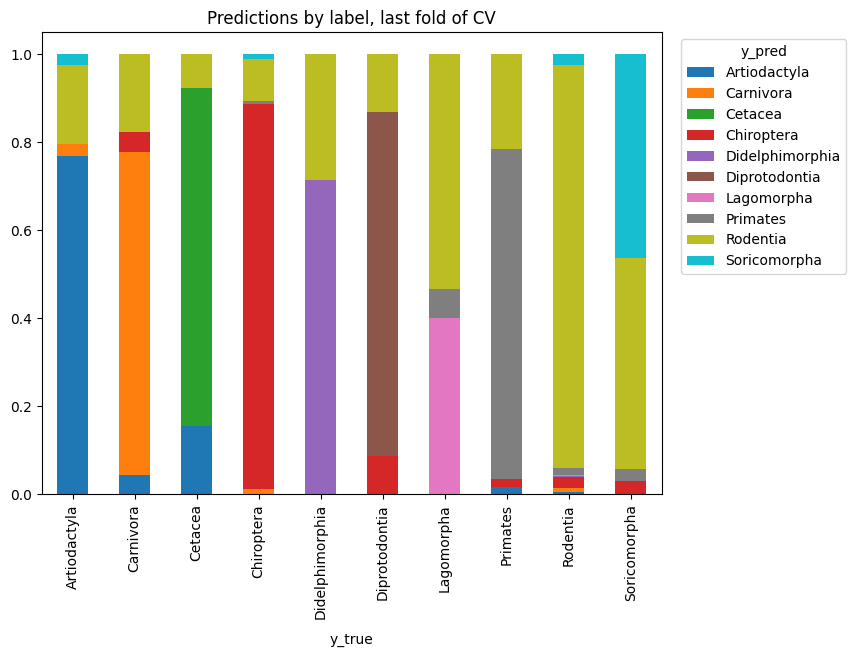

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))
preds_by_label.plot(kind='bar', stacked=True, ax=ax)


ax.set_xlabel('y_true', labelpad=10)
ax.set_title('Predictions by label, last fold of CV')
ax.legend(title='y_pred', bbox_to_anchor=(1.02, 1))

plt.show()

The model is particularly susceptible to classifying lagomorphs and soricomorphs as rodents, and predictions of Rodentia can be found in all orders. Given that the training data is greatly imbalanced towards Rodentia, resampling might improve the classifier's accuracy. Two particular methods of resampling will be tested: in the first case, the model will randomly undersample the majority order&mdash;Rodentia&mdash;to one-fourth its prevalence in the training set, while in the second case, the model will randomly oversample the number of instances of all non-majority orders (non-Rodentia orders) up to the number of Rodentia instances in the training set.

In [66]:
# The imbalance in the dataset

y_train.value_counts()

Rodentia           1821
Chiroptera          893
Soricomorpha        342
Primates            301
Carnivora           229
Artiodactyla        192
Diprotodontia       114
Lagomorpha           74
Didelphimorphia      70
Cetacea              67
Name: Order, dtype: int64

In [67]:
def one_fourth_rodentia(y_train_enc):
    """
    Find the count of the most-frequently occurring label in y_train_enc (a NumPy array), divide this count by 4,
    and return a dictionary associating the most-frequently occuring label (key) with this new reduced count (value). 
    
    Given that cross validation is conducted with StratifiedKFold and that the original train-test split was 
    stratified by label, the most-frequently occurring label in any given training set will be Rodentia.
    """
    labels, counts = np.unique(y_train_enc, return_counts=True)
    rodentia_index = np.argmax(counts)  # Index of most frequently-occurring label (Rodentia)
    rodentia_count = counts[rodentia_index]  
    one_fourth_rodentia_count = int(rodentia_count/4)
    return {rodentia_index: one_fourth_rodentia_count}

In [68]:
# Model with undersampling of Rodentia to one-fourth its prevalence in the training data

undersampler = RandomUnderSampler(sampling_strategy=one_fourth_rodentia, 
                                      random_state=42)
best_estimator_undersample = ImbPipeline(clone(best_estimator_cat_and_no_impute).steps)
best_estimator_undersample.steps.insert(-1, ('undersampler', undersampler))

In [69]:
# CV with undersampling

skf = StratifiedKFold(n_splits=5)
scores = np.zeros(skf.get_n_splits())

for i, (train_indexes_under, test_indexes_under) in enumerate(skf.split(X_train, y_train)):

    le_under = LabelEncoder()
    y_train_enc_under = le_under.fit_transform(y_train.iloc[train_indexes_under])

    best_estimator_undersample.fit(X_train.iloc[train_indexes_under], y_train_enc_under)
    pred_y_test_enc_under = best_estimator_undersample.predict(X_train.iloc[test_indexes_under])

    y_test_enc_under = le_under.transform(y_train.iloc[test_indexes_under])
    scores[i] = balanced_accuracy_score(y_test_enc_under, pred_y_test_enc_under)

print(f'CV balanced accuracy with undersampling of Rodentia: {scores.mean():.3f}')

CV balanced accuracy with undersampling of Rodentia: 0.789


In [70]:
# True vs predicted from final fold of CV (undersampling)

true_vs_pred_under = pd.DataFrame({'y_true': y_train.iloc[test_indexes_under],
                                   'y_pred': le.inverse_transform(pred_y_test_enc_under)})

preds_by_label_under = true_vs_pred_under.groupby('y_true')['y_pred'].value_counts(normalize=True)
preds_by_label_under = preds_by_label_under.unstack()
preds_by_label_under.round(2)

y_pred           Artiodactyla  Carnivora  Cetacea  Chiroptera  \
y_true                                                          
Artiodactyla             0.77       0.03      NaN        0.03   
Carnivora                0.04       0.80      NaN        0.02   
Cetacea                  0.15        NaN     0.77         NaN   
Chiroptera                NaN       0.01      NaN        0.89   
Didelphimorphia           NaN        NaN      NaN         NaN   
Diprotodontia             NaN        NaN      NaN        0.09   
Lagomorpha                NaN       0.07      NaN         NaN   
Primates                 0.02        NaN      NaN        0.05   
Rodentia                 0.01       0.02      NaN        0.06   
Soricomorpha              NaN        NaN      NaN        0.07   

y_pred           Didelphimorphia  Diprotodontia  Lagomorpha  Primates  \
y_true                                                                  
Artiodactyla                 NaN            NaN         NaN      0.08   
Carnivora                    NaN            NaN         NaN       NaN   
Cetacea                      NaN            NaN         NaN       NaN   
Chiroptera                   NaN            NaN         NaN      0.02   
Didelphimorphia             0.93            NaN         NaN       NaN   
Diprotodontia                NaN           0.87         NaN       NaN   
Lagomorpha                   NaN            NaN        0.53      0.07   
Primates                     NaN            NaN         NaN      0.82   
Rodentia                    0.01            NaN        0.02      0.05   
Soricomorpha                 NaN            NaN         NaN      0.07   

y_pred           Rodentia  Soricomorpha  
y_true                                   
Artiodactyla         0.03          0.08  
Carnivora            0.11          0.02  
Cetacea              0.08           NaN  
Chiroptera           0.04          0.04  
Didelphimorphia      0.07           NaN  
Diprotodontia        0.04           NaN  
Lagomorpha           0.33           NaN  
Primates             0.10          0.02  
Rodentia             0.74          0.09  
Soricomorpha         0.30          0.55

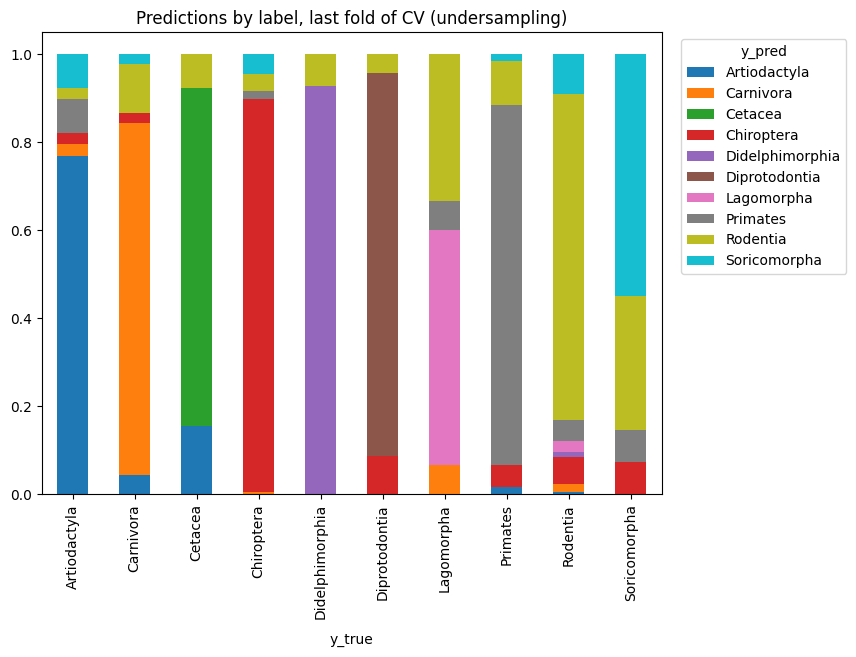

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
preds_by_label_under.plot(kind='bar', stacked=True, ax=ax)


ax.set_xlabel('y_true', labelpad=10)
ax.set_title('Predictions by label, last fold of CV (undersampling)')
ax.legend(title='y_pred', bbox_to_anchor=(1.02, 1))

plt.show()

In [72]:
# Model with random oversampling of all non-majority orders

oversampler = RandomOverSampler(random_state=42)
best_estimator_oversample = ImbPipeline(clone(best_estimator_cat_and_no_impute).steps)
best_estimator_oversample.steps.insert(-1, ('oversampler', oversampler))

In [73]:
# CV with oversampling

skf = StratifiedKFold(n_splits=5)
scores = np.zeros(skf.get_n_splits())

for i, (train_indexes_over, test_indexes_over) in enumerate(skf.split(X_train, y_train)):

    le_over = LabelEncoder()
    y_train_enc_over = le_over.fit_transform(y_train.iloc[train_indexes_over])

    best_estimator_oversample.fit(X_train.iloc[train_indexes_over], y_train_enc_over)
    pred_y_test_enc_over = best_estimator_oversample.predict(X_train.iloc[test_indexes_over])

    y_test_enc_over = le_over.transform(y_train.iloc[test_indexes_over])
    scores[i] = balanced_accuracy_score(y_test_enc_over, pred_y_test_enc_over)

print(f'CV balanced accuracy with oversampling of non-majority classes: {scores.mean():.3f}')

CV balanced accuracy with oversampling of non-majority classes: 0.788


In [74]:
# True vs predicted from final fold of CV (oversampling)

true_vs_pred_over = pd.DataFrame({'y_true': y_train.iloc[test_indexes_over],
                                  'y_pred': le.inverse_transform(pred_y_test_enc_over)})

preds_by_label_over = true_vs_pred_over.groupby('y_true')['y_pred'].value_counts(normalize=True)
preds_by_label_over = preds_by_label_over.unstack()
preds_by_label_over.round(2)

y_pred           Artiodactyla  Carnivora  Cetacea  Chiroptera  \
y_true                                                          
Artiodactyla             0.77        NaN      NaN        0.03   
Carnivora                0.02       0.84      NaN        0.02   
Cetacea                  0.08        NaN     0.85         NaN   
Chiroptera                NaN       0.02      NaN        0.86   
Didelphimorphia           NaN        NaN      NaN         NaN   
Diprotodontia             NaN        NaN      NaN        0.09   
Lagomorpha                NaN        NaN      NaN         NaN   
Primates                 0.02        NaN      NaN        0.05   
Rodentia                 0.00       0.01      NaN        0.02   
Soricomorpha              NaN        NaN      NaN        0.03   

y_pred           Didelphimorphia  Diprotodontia  Lagomorpha  Primates  \
y_true                                                                  
Artiodactyla                 NaN            NaN         NaN       NaN   
Carnivora                    NaN            NaN         NaN       NaN   
Cetacea                      NaN            NaN         NaN       NaN   
Chiroptera                   NaN            NaN         NaN      0.02   
Didelphimorphia             0.86            NaN         NaN       NaN   
Diprotodontia                NaN           0.87         NaN       NaN   
Lagomorpha                   NaN            NaN        0.47      0.13   
Primates                     NaN            NaN         NaN      0.77   
Rodentia                    0.01            NaN        0.01      0.02   
Soricomorpha                 NaN            NaN         NaN      0.03   

y_pred           Rodentia  Soricomorpha  
y_true                                   
Artiodactyla         0.15          0.05  
Carnivora            0.04          0.07  
Cetacea               NaN          0.08  
Chiroptera           0.05          0.05  
Didelphimorphia      0.14           NaN  
Diprotodontia         NaN          0.04  
Lagomorpha           0.40           NaN  
Primates             0.15          0.02  
Rodentia             0.76          0.16  
Soricomorpha         0.23          0.71

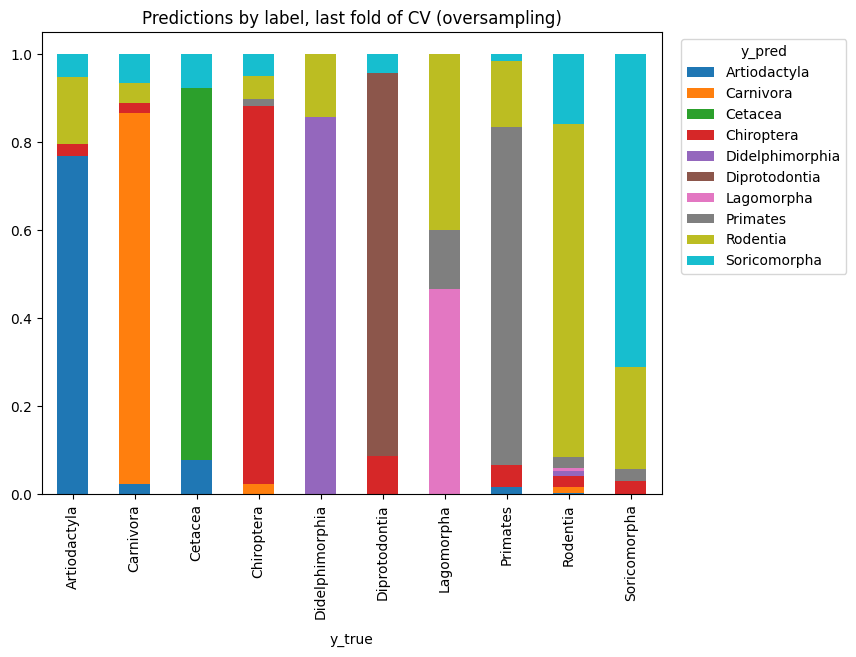

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))
preds_by_label_over.plot(kind='bar', stacked=True, ax=ax)


ax.set_xlabel('y_true', labelpad=10)
ax.set_title('Predictions by label, last fold of CV (oversampling)')
ax.legend(title='y_pred', bbox_to_anchor=(1.02, 1))

plt.show()

 Both undersampling and oversampling improved model performance on lagomorphs and soricomorphs, and balanced accuracy as a whole exceeded that of the non-resampled model in both cases (non-resampled=0.748; undersampled=0.789; oversampled=0.788). The undersampled model marginally outperformed the oversampled model, thus rendering it the best-performing classifier out of all those tested in preceding rounds of cross validation and fine-tuning. Before proceeding with this model to final evaluation on the test set, in-sample accuracy will be determined once more to see if the model could benefit from increased regularization.

In [76]:
# Gauging in-sample accuracy and extent of overfitting

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

best_estimator_undersample.fit(X_train, y_train_enc)
pred_y_train_enc = best_estimator_undersample.predict(X_train)
in_sample_accuracy = balanced_accuracy_score(y_train_enc, pred_y_train_enc)

print(f'In-sample balanced accuracy (undersampling): {in_sample_accuracy:.3f}')

In-sample balanced accuracy (undersampling): 0.933


As with the non-resampled model, in-sample accuracy noticeably exceeds out-of-sample accuracy (0.933 vs 0.789). ```min_samples_leaf``` will be increased to see if further out-of-sample accuracy can be extracted.

In [77]:
# Increasing min_samples_leaf from 50 to 250

regularized_model = clone(best_estimator_undersample).set_params(clf__min_samples_leaf=250)

regularized_model_cv_scores = cross_val_score(regularized_model, X_train, y_train_enc, 
                                              scoring='balanced_accuracy', cv=5, n_jobs=-1)

print(f'Out-of-sample balanced accuracy (undersampling; min_samples_leaf=250): {regularized_model_cv_scores.mean():.3f}')

Out-of-sample balanced accuracy (undersampling; min_samples_leaf=250): 0.778


Increasing ```min_samples_leaf``` did not improve accuracy; the original undersampled model with ```min_samples_leaf``` equal to 50 will thus be the version taken to test set evaluation. Final cross-validation statistics are below.

In [78]:
scores = cross_val_score(best_estimator_undersample, X_train, y_train_enc, 
                         scoring='balanced_accuracy', cv=5, n_jobs=-1)

print(f'CV mean balanced accuracy: {scores.mean():.3f}')
print(f'CV standard deviation of balanced accuracy: {scores.std():.3f}')

CV mean balanced accuracy: 0.789
CV standard deviation of balanced accuracy: 0.015


In [79]:
best_estimator_finetuned = clone(best_estimator_undersample)
best_estimator_finetuned

Pipeline(steps=[('ct1',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   FunctionTransformer(func=<function df_to_array at 0x000001380D2CE700>)),
                                                                  ('handle_skewness',
                                                                   SkewTransformer(log_thresh_abs=6,
                                                                                   sqrt_thresh_abs=3)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('reduce_dim',
                                                                   'passthrough')]),
                                                  ['AdultBodyMass_g',
                                                   'AdultHeadBodyLen_mm',
                                                   'AgeatFirstBirt...
                                                  ['ActivityCycle',
                                                   'Terrestriality',
                                                   'TrophicLevel'])])),
                ('ct2', 'passthrough'),
                ('undersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=<function one_fourth_rodentia at 0x000001380D27C0D0>)),
                ('clf',
                 HistGradientBoostingClassifier(categorical_features=[37, 38,
                                                                      39],
                                                l2_regularization=10.0,
                                                learning_rate=0.01,
                                                max_iter=2000,
                                                min_samples_leaf=50,
                                                random_state=42))])

## Evaluation on Test Set

In [80]:
le_test = LabelEncoder()
y_train_enc = le_test.fit_transform(y_train)

best_estimator_finetuned.fit(X_train, y_train_enc)
pred_y_test_enc = best_estimator_finetuned.predict(X_test)

y_test_enc = le_test.transform(y_test)
score = balanced_accuracy_score(y_test_enc, pred_y_test_enc)

print(f'Test set balanced accuracy: {score:.3f}')

Test set balanced accuracy: 0.785


In [81]:
# True vs predicted from test set

true_vs_pred_test = pd.DataFrame({'y_true': y_test,
                                  'y_pred': le_test.inverse_transform(pred_y_test_enc)})

preds_by_label_test = true_vs_pred_test.groupby('y_true')['y_pred'].value_counts(normalize=True)
preds_by_label_test = preds_by_label_test.unstack()
preds_by_label_test.round(2)

y_pred           Artiodactyla  Carnivora  Cetacea  Chiroptera  \
y_true                                                          
Artiodactyla             0.81        NaN      NaN        0.02   
Carnivora                 NaN       0.91      NaN        0.04   
Cetacea                  0.06        NaN     0.88         NaN   
Chiroptera                NaN       0.00      NaN        0.90   
Didelphimorphia           NaN        NaN      NaN         NaN   
Diprotodontia             NaN        NaN      NaN        0.10   
Lagomorpha                NaN        NaN      NaN         NaN   
Primates                  NaN        NaN      NaN        0.03   
Rodentia                 0.00       0.01      NaN        0.06   
Soricomorpha             0.01        NaN      NaN        0.08   

y_pred           Didelphimorphia  Diprotodontia  Lagomorpha  Primates  \
y_true                                                                  
Artiodactyla                 NaN           0.02         NaN      0.06   
Carnivora                    NaN            NaN         NaN      0.04   
Cetacea                      NaN            NaN         NaN       NaN   
Chiroptera                   NaN            NaN         NaN      0.02   
Didelphimorphia             0.76            NaN         NaN       NaN   
Diprotodontia                NaN           0.86         NaN       NaN   
Lagomorpha                   NaN            NaN        0.50      0.06   
Primates                     NaN            NaN         NaN      0.88   
Rodentia                    0.02           0.01        0.02      0.03   
Soricomorpha                 NaN            NaN        0.01      0.02   

y_pred           Rodentia  Soricomorpha  
y_true                                   
Artiodactyla         0.08           NaN  
Carnivora            0.02           NaN  
Cetacea              0.06           NaN  
Chiroptera           0.04          0.03  
Didelphimorphia      0.24           NaN  
Diprotodontia        0.03           NaN  
Lagomorpha           0.28          0.17  
Primates             0.07          0.03  
Rodentia             0.79          0.06  
Soricomorpha         0.33          0.55

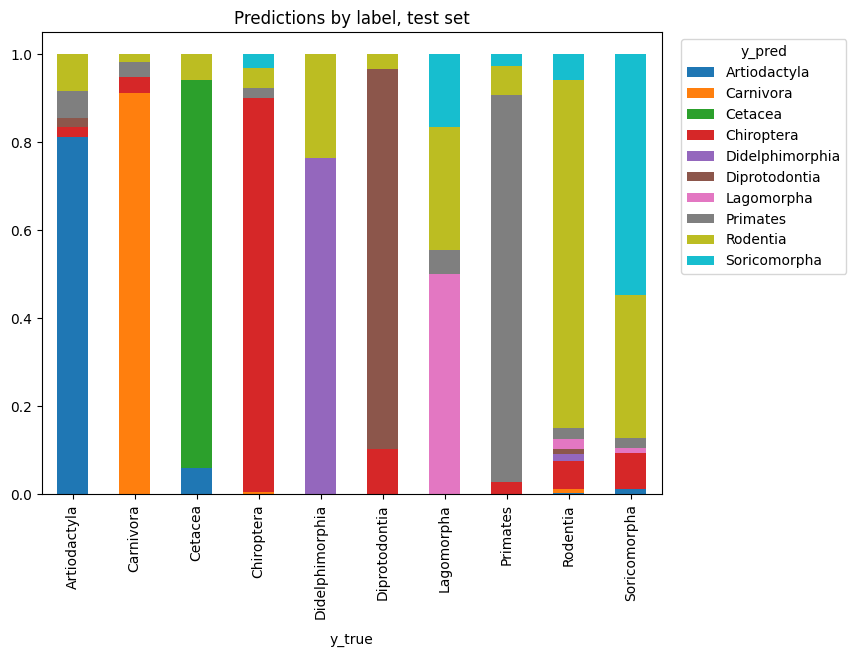

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
preds_by_label_test.plot(kind='bar', stacked=True, ax=ax)


ax.set_xlabel('y_true', labelpad=10)
ax.set_title('Predictions by label, test set')
ax.legend(title='y_pred', bbox_to_anchor=(1.02, 1))

plt.show()

In [83]:
print(classification_report(y_test_enc, pred_y_test_enc, target_names=le.classes_, digits=3))

                 precision    recall  f1-score   support

   Artiodactyla      0.929     0.812     0.867        48
      Carnivora      0.912     0.912     0.912        57
        Cetacea      1.000     0.882     0.938        17
     Chiroptera      0.820     0.897     0.857       223
Didelphimorphia      0.619     0.765     0.684        17
  Diprotodontia      0.806     0.862     0.833        29
     Lagomorpha      0.450     0.500     0.474        18
       Primates      0.725     0.880     0.795        75
       Rodentia      0.859     0.789     0.823       456
   Soricomorpha      0.547     0.547     0.547        86

       accuracy                          0.805      1026
      macro avg      0.767     0.785     0.773      1026
   weighted avg      0.810     0.805     0.806      1026



## Training on Entire Dataset

In [84]:
le_entire = LabelEncoder()
y_enc = le_entire.fit_transform(y)

best_estimator_finetuned.fit(X, y_enc)

Pipeline(steps=[('ct1',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   FunctionTransformer(func=<function df_to_array at 0x000001380D2CE700>)),
                                                                  ('handle_skewness',
                                                                   SkewTransformer(log_thresh_abs=6,
                                                                                   sqrt_thresh_abs=3)),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('reduce_dim',
                                                                   'passthrough')]),
                                                  ['AdultBodyMass_g',
                                                   'AdultHeadBodyLen_mm',
                                                   'AgeatFirstBirt...
                                                  ['ActivityCycle',
                                                   'Terrestriality',
                                                   'TrophicLevel'])])),
                ('ct2', 'passthrough'),
                ('undersampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=<function one_fourth_rodentia at 0x000001380D27C0D0>)),
                ('clf',
                 HistGradientBoostingClassifier(categorical_features=[37, 38,
                                                                      39],
                                                l2_regularization=10.0,
                                                learning_rate=0.01,
                                                max_iter=2000,
                                                min_samples_leaf=50,
                                                random_state=42))])

In [85]:
# Saving final classifier

with open('classifier.pkl', 'wb') as f:
    pickle.dump(best_estimator_finetuned, f)

## Summary

Trait data for thousands of mammalian species were obtained from PanTHERIA, a comprehensive species-level database of mammalian traits. These data were imported into the file, received preliminary cleaning (e.g., inserting estimates into empirically-derived columns, filtering for the 10 most-frequent orders), and were subsequently partitioned into a train set and test set in a stratified fashion. Exploratory data analysis with the train set followed in Pandas, dropping features with insufficient data and assessing the visual and statistical impacts of missing-value imputation, skewness transformations, standardization, dimensionality reduction via PCA, and one-hot encoding. Based on these transformations, a preprocessing pipeline was formulated in Scikit-learn, where it was then tested using grid-search cross validation (CV) with a variety of different classifier types&mdash;decision trees, random forests, gradient boosting classifiers (GBCs), and support vector classifiers with different kernels. The best-performing classifiers from this round of CV&mdash;as judged by mean balanced accuracy across 5 stratified splits of the training data&mdash;were random forests and gradient boosting classifiers; these classifiers performed optimally when they did not reduce the original dimensionality of the numeric features. Having narrowed down the classifiers to these two types, random forests and GBCs were each run through 200 iterations of CV with randomized hyperparameter settings; random forests varied over metrics such as number of constituent trees and the minimum number of samples to split an internal node, while GBCs varied across learning rate, minimum leaf size, L2 regularization, and maximum number of boosting iterations. Both types of models were also allowed to vary over the imputing method for numeric features and the precise skewness thresholds around which to apply log transformations and square-root transformations.

Across these combined 400 rounds of cross validation, GBCs outperformed random forests both overall and at the extreme upper edge of performance, with top-performers making use of a mean imputation strategy and a maximum of 500 or more boosting iterations. It was then discovered that the top classifier from all these 400 rounds&mdash;a GBC with a learning rate of 0.01, a minimum leaf size of 50, and a maximum of 2000 iterations of the boosting process&mdash;could be improved even further by leaving missing values untouched and by specifying categorical features by index&mdash;eliminating the need for one-hot encoding. Examining this model's precise prediction errors, it was notable that predictions of Rodentia could be found in every single order&mdash;particularly in lagomorphs and soricomorphs, which obtained mediocre recall scores. Given the training data's great imbalance toward Rodentia, two resampling techniques were evaluated: in the first case, the model randomly undersampled the majority order&mdash;Rodentia&mdash;to one-fourth its prevalence in the training set, while in the second case, the model randomly oversampled the number of instances of all non-majority orders (non-Rodentia orders) up to the number of Rodentia instances in the training set. Both of these techniques led to noteworthy performance improvements compared to the non-resampled model, but the undersampled model marginally outperformed the oversampled model. After determining that this undersampled model did not perform better with more regularization, it was taken to final evaluation on the test set, where it achieved a balanced accuracy of 0.785 and a recall score of at least 0.75 on eight out of the ten orders considered. The classifier was then trained on the entire pre-partitioned dataset and saved down as a byte stream for future use.

## Data Sources and Citations

All data come from the PanTHERIA database (Jones et al., 2009), using the taxonomy set forth by Wilson and Reeder in 2005 (Wilson & Reeder, 2005). Raw data can be found [here](https://esapubs.org/archive/ecol/E090/184/PanTHERIA_1-0_WR05_Aug2008.txt), with accompanying metadata [here](https://esapubs.org/archive/ecol/E090/184/metadata.htm). Full citations are below.

Jones, K. E., Bielby, J., Cardillo, M., Fritz, S. A., O'Dell, J., Orme, C. D., Safi, K., Sechrest, W., Boakes, E. H., Carbone, C., Connolly, C., Cutts, M. J., Foster, J. K., Grenyer, R., Habib, M., Plaster, C. A., Price, S. A., Rigby, E. A., Rist, J., . . . Purvis, A. (2009). PanTHERIA: a species-level database of life history, ecology, and geography of extant and recently extinct mammals. Ecology, 90(9), 2648. https://doi.org/10.1890/08-1494.1

Wilson, D. E., & Reeder, D. M. (2005). Mammal species of the world: a taxonomic and geographic reference. JHU press.

## Tools Used

NumPy, Pandas, Scikit-learn, Imbalanced-learn, SciPy, Matplotlib, Seaborn